# Part 3: Embedding Visualization and Interpretation

## Installation Requirements

In [1]:
!pip install torch numpy matplotlib scikit-learn seaborn

## Import Libraries

In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Model architecture definition (same as training)
import torch.nn as nn

def create_mlp_model(vocab_size, embedding_dim, hidden_size, context_length, activation='relu'):
    """
    Create MLP model for next-word prediction
    """
    
    class MLPWordPredictor(nn.Module):
        def __init__(self):
            super(MLPWordPredictor, self).__init__()
            
            # Embedding layer
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            
            # Calculate input size to hidden layer
            input_size = context_length * embedding_dim
            
            # Hidden layer
            self.fc1 = nn.Linear(input_size, hidden_size)
            
            # Activation function
            if activation == 'relu':
                self.activation = nn.ReLU()
            elif activation == 'tanh':
                self.activation = nn.Tanh()
            else:
                raise ValueError("Activation must be 'relu' or 'tanh'")
            
            # Output layer
            self.fc2 = nn.Linear(hidden_size, vocab_size)
            
        def forward(self, x):
            embedded = self.embedding(x)
            embedded = embedded.reshape(embedded.size(0), -1)
            hidden = self.activation(self.fc1(embedded))
            output = self.fc2(hidden)
            return output
        
        def get_embeddings(self):
            """Return the embedding weights"""
            return self.embedding.weight.detach().cpu().numpy()
    
    return MLPWordPredictor()


In [4]:
import pickle

# Load vocab maps from the dataset files once
with open('wikipedia_processed.pkl', 'rb') as f:
    wiki_data = pickle.load(f)
with open('linux_processed.pkl', 'rb') as f:
    linux_data = pickle.load(f)

def get_vocab_maps(model_name):
    """Return (word_to_idx, idx_to_word, dataset_type) for a model."""
    if model_name.startswith("wiki_"):
        return wiki_data['word_to_idx'], wiki_data['idx_to_word'], 'wikipedia'
    elif model_name.startswith("linux_"):
        return linux_data['word_to_idx'], linux_data['idx_to_word'], 'linux'
    else:
        raise ValueError(f"Unknown model name prefix for {model_name}")


## Load Trained Models

In [5]:
# Load all models and results
print("Loading trained models...")
with open('all_models_results.pkl', 'rb') as f:
    all_models = pickle.load(f)

print(f"✅ Loaded {len(all_models)} trained models")
print("Available models:", list(all_models.keys()))


Loading trained models...
✅ Loaded 8 trained models
Available models: ['wiki_64d-ReLU', 'wiki_32d-ReLU', 'wiki_64d-tanh', 'wiki_32d-tanh', 'linux_64d-ReLU', 'linux_32d-ReLU', 'linux_64d-tanh', 'linux_32d-tanh']


In [6]:
def load_model_if_needed(model_data, model_name):
    """Load model from checkpoint if not in memory"""
    model = model_data.get('model')
    
    if model is not None:
        return model
    
    # Load from checkpoint
    ckpt_path = f"{model_name}_best.pth"
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint {ckpt_path} not found")
    
    # Recreate architecture
    vocab_size = model_data['vocab_size']
    embedding_dim = 64 if '64d' in model_name else 32
    activation = 'tanh' if 'tanh' in model_name else 'relu'
    
    model = create_mlp_model(vocab_size, embedding_dim, 1024, 5, activation)
    
    # Load weights
    ckpt = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()
    
    return model

## Embedding Extraction Function

In [7]:
def extract_embeddings(model):
    """Extract embedding weights from trained model"""
    model.eval()
    embeddings = model.get_embeddings()
    return embeddings

## Word Selection for Visualization

In [8]:
def select_interesting_words(word_to_idx, idx_to_word, word_counts, dataset_type='wikipedia'):
    """
    Select interesting words for visualization:
    - Common words
    - Related word groups (synonyms, antonyms, etc.)
    - Technical terms for code
    """
    
    if dataset_type == 'wikipedia':
        # Natural language - select semantic groups
        word_groups = {
            'pronouns': ['i', 'you', 'he', 'she', 'we', 'they', 'it'],
            'verbs_motion': ['go', 'come', 'run', 'walk', 'move', 'travel'],
            'verbs_communication': ['say', 'tell', 'speak', 'talk', 'write'],
            'time': ['day', 'night', 'year', 'month', 'time', 'hour'],
            'common_nouns': ['man', 'woman', 'people', 'person', 'world', 'life'],
            'adjectives': ['good', 'bad', 'big', 'small', 'new', 'old'],
            'numbers': ['one', 'two', 'three', 'first', 'second'],
            'locations': ['here', 'there', 'where', 'place', 'city'],
        }
    else:
        # Code - select programming-related groups
        word_groups = {
            'keywords': ['if', 'else', 'for', 'while', 'return', 'int', 'void'],
            'operators': ['and', 'or', 'not', 'is'],
            'common_functions': ['get', 'set', 'init', 'free', 'alloc'],
            'data_types': ['int', 'char', 'void', 'struct', 'long'],
            'pointers': ['ptr', 'addr', 'ref'],
            'common_vars': ['i', 'j', 'k', 'x', 'y', 'n', 'ret'],
        }
    
    selected_words = []
    selected_labels = []
    
    for group_name, words in word_groups.items():
        for word in words:
            if word in word_to_idx:
                selected_words.append(word)
                selected_labels.append(group_name)
    
    # Also add top 20 most frequent words
    most_common = word_counts.most_common(30)
    for word, count in most_common:
        if word not in ['<PAD>', '<UNK>', '<EOS>'] and word not in selected_words:
            if len(selected_words) < 100:  # Limit total words
                selected_words.append(word)
                selected_labels.append('common')
    
    return selected_words, selected_labels


## Visualization Functions

In [9]:
def visualize_embeddings_tsne(embeddings, words, labels, idx_to_word, word_to_idx, model_name, 
                               perplexity=30, n_iter=1000):
    """
    Visualize embeddings using t-SNE
    """
    # Get word indices
    word_indices = [word_to_idx[word] for word in words if word in word_to_idx]
    actual_words = [word for word in words if word in word_to_idx]
    actual_labels = [labels[i] for i, word in enumerate(words) if word in word_to_idx]
    
    # Extract embeddings for selected words
    word_embeddings = embeddings[word_indices]
    
    print(f"Visualizing {len(word_embeddings)} word embeddings for {model_name}...")
    
    # Apply t-SNE
    perplexity = min(perplexity, len(word_embeddings) - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=n_iter)
    embeddings_2d = tsne.fit_transform(word_embeddings)
    
    # Create plot
    plt.figure(figsize=(16, 12))
    
    # Color map for different groups
    unique_labels = list(set(actual_labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_to_color = dict(zip(unique_labels, colors))
    
    # Plot each group
    for label in unique_labels:
        indices = [i for i, l in enumerate(actual_labels) if l == label]
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], 
                   c=[label_to_color[label]], label=label, alpha=0.7, s=100, edgecolors='black', linewidths=0.5)
    
    # Annotate words
    for i, word in enumerate(actual_words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                    fontsize=9, alpha=0.8, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    
    plt.xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
    plt.ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
    plt.title(f'Word Embeddings Visualization - {model_name}\\n(t-SNE)', 
              fontsize=16, fontweight='bold')
    plt.legend(loc='best', fontsize=10, framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{model_name}_embeddings_tsne.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Visualization saved as '{model_name}_embeddings_tsne.png'")
    
    return embeddings_2d

def visualize_embeddings_2d(embeddings, words, labels, idx_to_word, word_to_idx, model_name):
    """
    Visualize 2D embeddings directly (if embedding_dim == 2)
    Otherwise use PCA to reduce to 2D
    """
    embedding_dim = embeddings.shape[1]
    
    # Get word indices
    word_indices = [word_to_idx[word] for word in words if word in word_to_idx]
    actual_words = [word for word in words if word in word_to_idx]
    actual_labels = [labels[i] for i, word in enumerate(words) if word in word_to_idx]
    
    # Extract embeddings
    word_embeddings = embeddings[word_indices]
    
    # Reduce to 2D if needed
    if embedding_dim > 2:
        print(f"Reducing {embedding_dim}D embeddings to 2D using PCA...")
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(word_embeddings)
        method = 'PCA'
    else:
        embeddings_2d = word_embeddings
        method = 'Direct'
    
    # Create plot
    plt.figure(figsize=(16, 12))
    
    # Color map
    unique_labels = list(set(actual_labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_to_color = dict(zip(unique_labels, colors))
    
    # Plot each group
    for label in unique_labels:
        indices = [i for i, l in enumerate(actual_labels) if l == label]
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], 
                   c=[label_to_color[label]], label=label, alpha=0.7, s=100, edgecolors='black', linewidths=0.5)
    
    # Annotate words
    for i, word in enumerate(actual_words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                    fontsize=9, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    
    plt.xlabel(f'Dimension 1 ({method})', fontsize=14, fontweight='bold')
    plt.ylabel(f'Dimension 2 ({method})', fontsize=14, fontweight='bold')
    plt.title(f'Word Embeddings Visualization - {model_name}\\n({method})', 
              fontsize=16, fontweight='bold')
    plt.legend(loc='best', fontsize=10, framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.savefig(f'{model_name}_embeddings_pca.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Visualization saved as '{model_name}_embeddings_pca.png'")
    
    return embeddings_2d

def analyze_embedding_distances(embeddings, words, word_to_idx, model_name, top_k=5):
    """
    Analyze distances between words in embedding space
    Find nearest neighbors for sample words
    """
    print(f"\n{'='*80}")
    print(f"Nearest Neighbors Analysis - {model_name}")
    print(f"{'='*80}")
    
    # Sample words to analyze
    sample_words = words[:10] if len(words) >= 10 else words
    
    from scipy.spatial.distance import cosine
    
    for sample_word in sample_words:
        if sample_word not in word_to_idx:
            continue
        
        sample_idx = word_to_idx[sample_word]
        sample_embedding = embeddings[sample_idx]
        
        # Calculate distances to all words
        distances = []
        for word in words:
            if word in word_to_idx and word != sample_word:
                word_idx = word_to_idx[word]
                word_embedding = embeddings[word_idx]
                
                # Cosine similarity
                similarity = 1 - cosine(sample_embedding, word_embedding)
                distances.append((word, similarity))
        
        # Sort by similarity
        distances.sort(key=lambda x: x, reverse=True)
        
        # Print top k nearest neighbors
        print(f"\n🔍 Word: '{sample_word}'")
        print(f"   Top {top_k} nearest neighbors:")
        for i, (neighbor, similarity) in enumerate(distances[:top_k], 1):
            print(f"      {i}. '{neighbor}' (similarity: {similarity:.4f})")


## Generate Visualizations for All Models


GENERATING EMBEDDING VISUALIZATIONS FOR ALL MODELS

Processing: wiki_64d-ReLU
Selected 73 words for visualization
Visualizing 73 word embeddings for wiki_64d-ReLU...


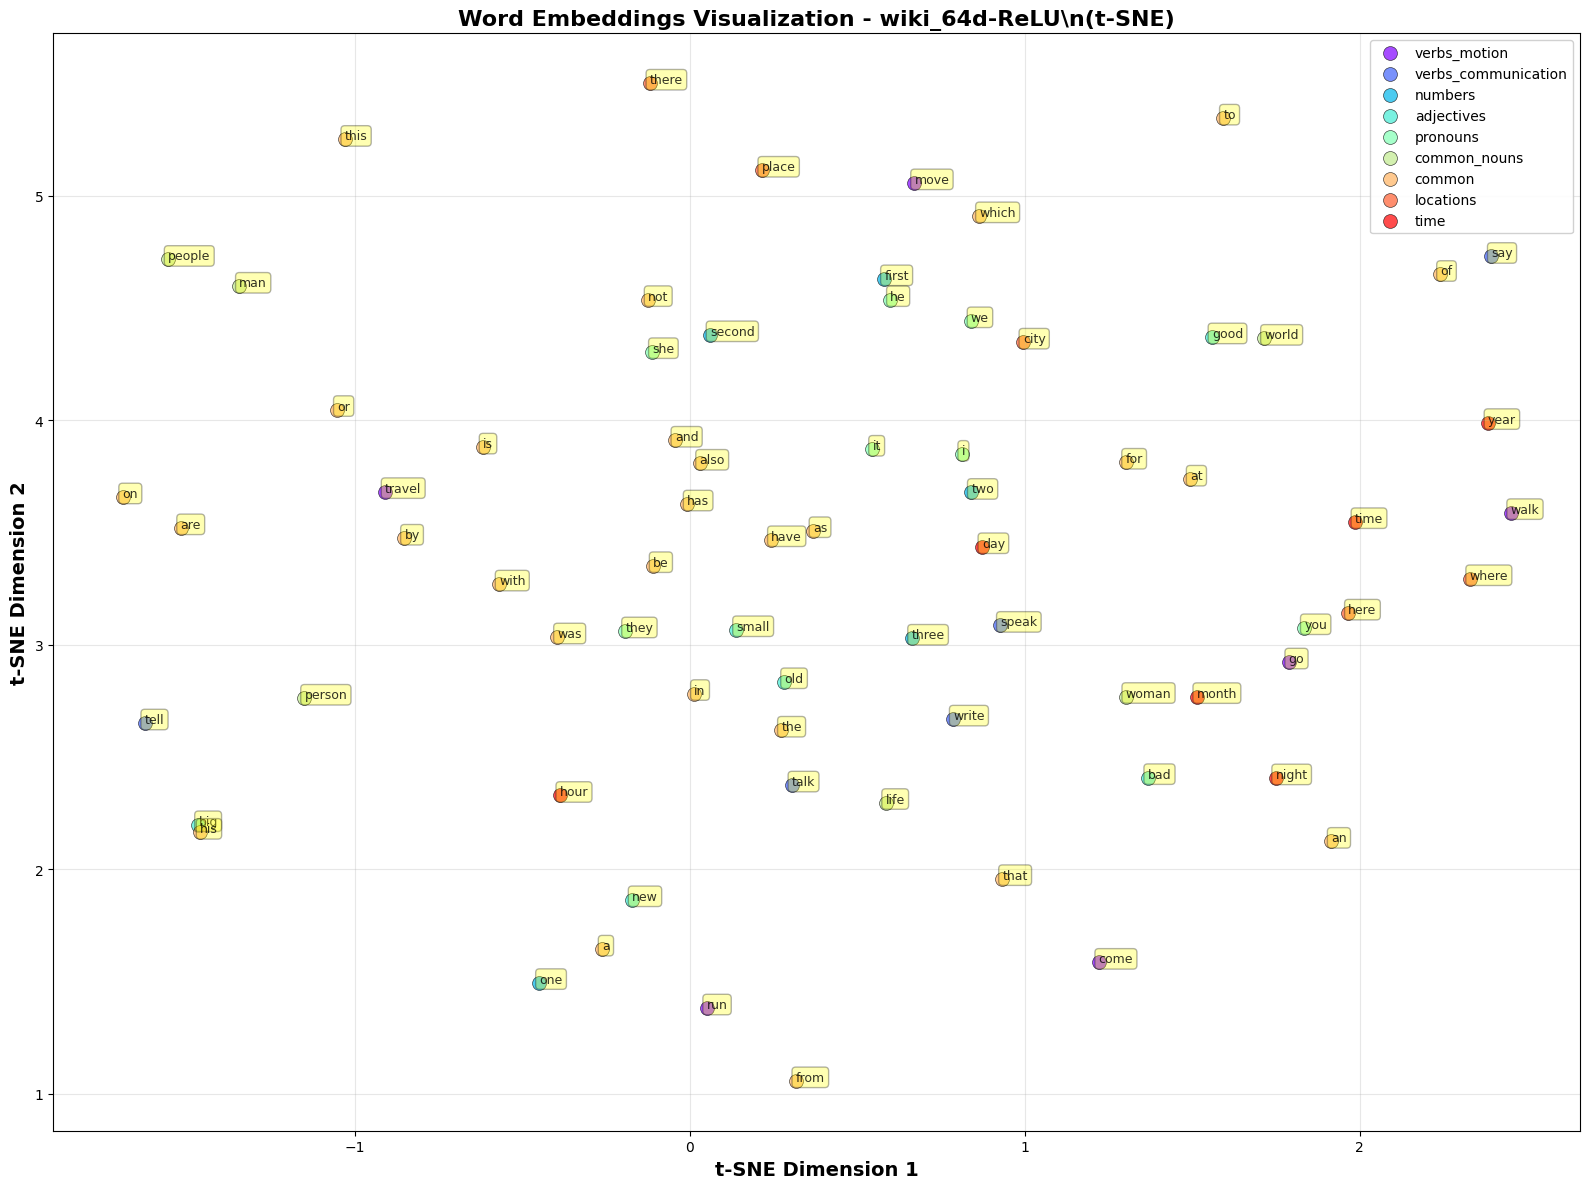

✅ Visualization saved as 'wiki_64d-ReLU_embeddings_tsne.png'
Reducing 64D embeddings to 2D using PCA...


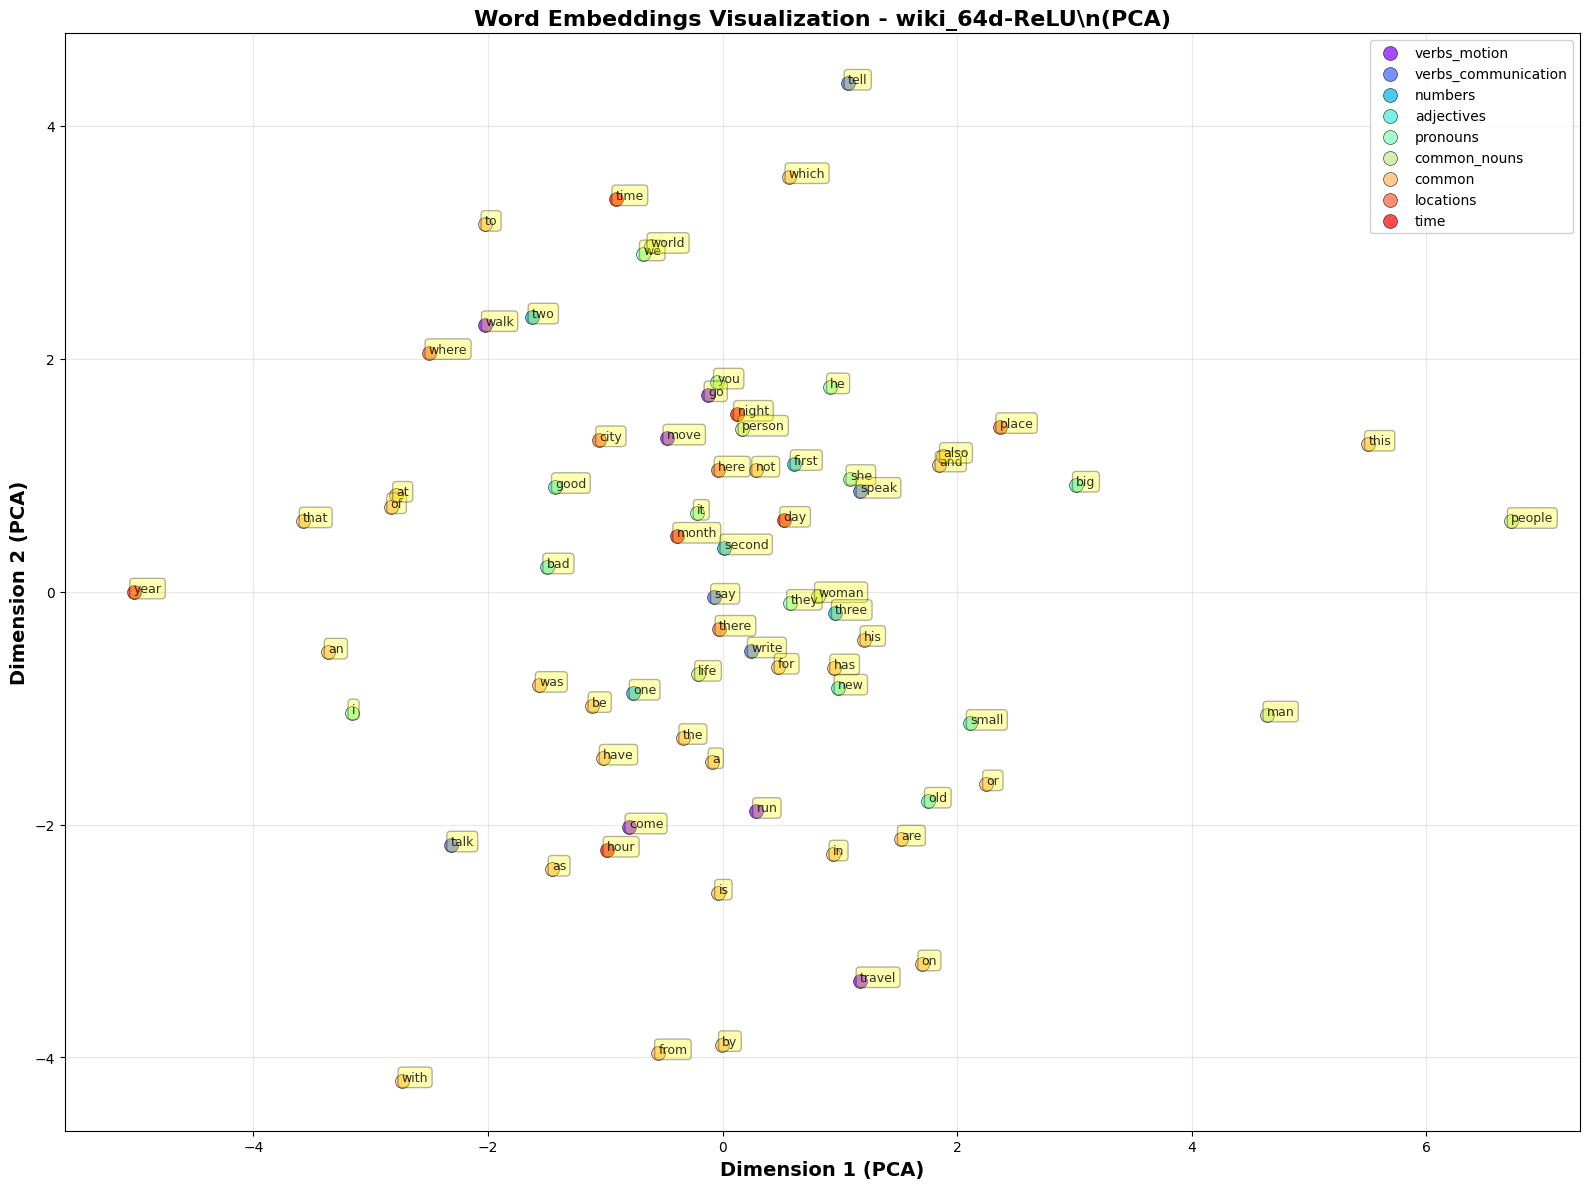

✅ Visualization saved as 'wiki_64d-ReLU_embeddings_pca.png'

Nearest Neighbors Analysis - wiki_64d-ReLU

🔍 Word: 'i'
   Top 5 nearest neighbors:
      1. 'you' (similarity: 0.1178)
      2. 'year' (similarity: 0.2273)
      3. 'write' (similarity: -0.1824)
      4. 'world' (similarity: 0.0113)
      5. 'woman' (similarity: -0.0998)

🔍 Word: 'you'
   Top 5 nearest neighbors:
      1. 'year' (similarity: -0.1824)
      2. 'write' (similarity: -0.0446)
      3. 'world' (similarity: 0.0429)
      4. 'woman' (similarity: -0.1965)
      5. 'with' (similarity: -0.2493)

🔍 Word: 'he'
   Top 5 nearest neighbors:
      1. 'you' (similarity: -0.0865)
      2. 'year' (similarity: 0.0179)
      3. 'write' (similarity: -0.1387)
      4. 'world' (similarity: 0.2091)
      5. 'woman' (similarity: 0.0794)

🔍 Word: 'she'
   Top 5 nearest neighbors:
      1. 'you' (similarity: -0.1280)
      2. 'year' (similarity: 0.1161)
      3. 'write' (similarity: -0.1370)
      4. 'world' (similarity: -0.0421)
     

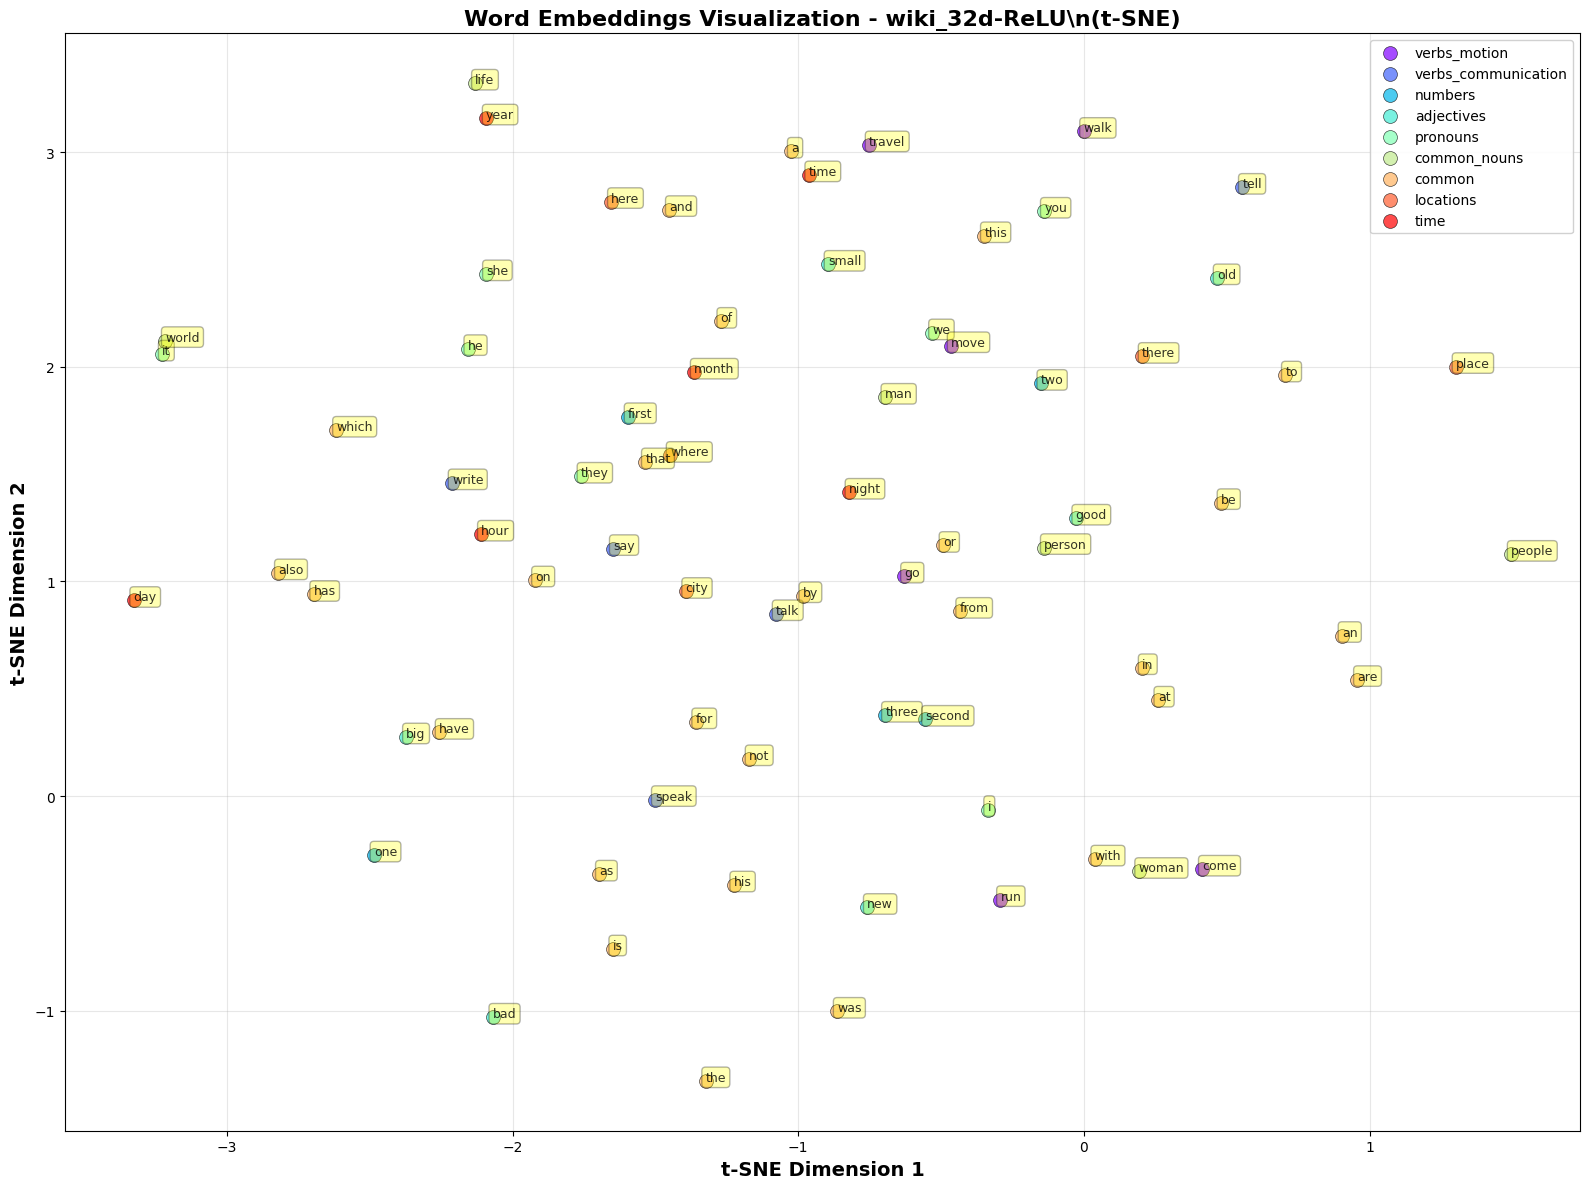

✅ Visualization saved as 'wiki_32d-ReLU_embeddings_tsne.png'
Reducing 32D embeddings to 2D using PCA...


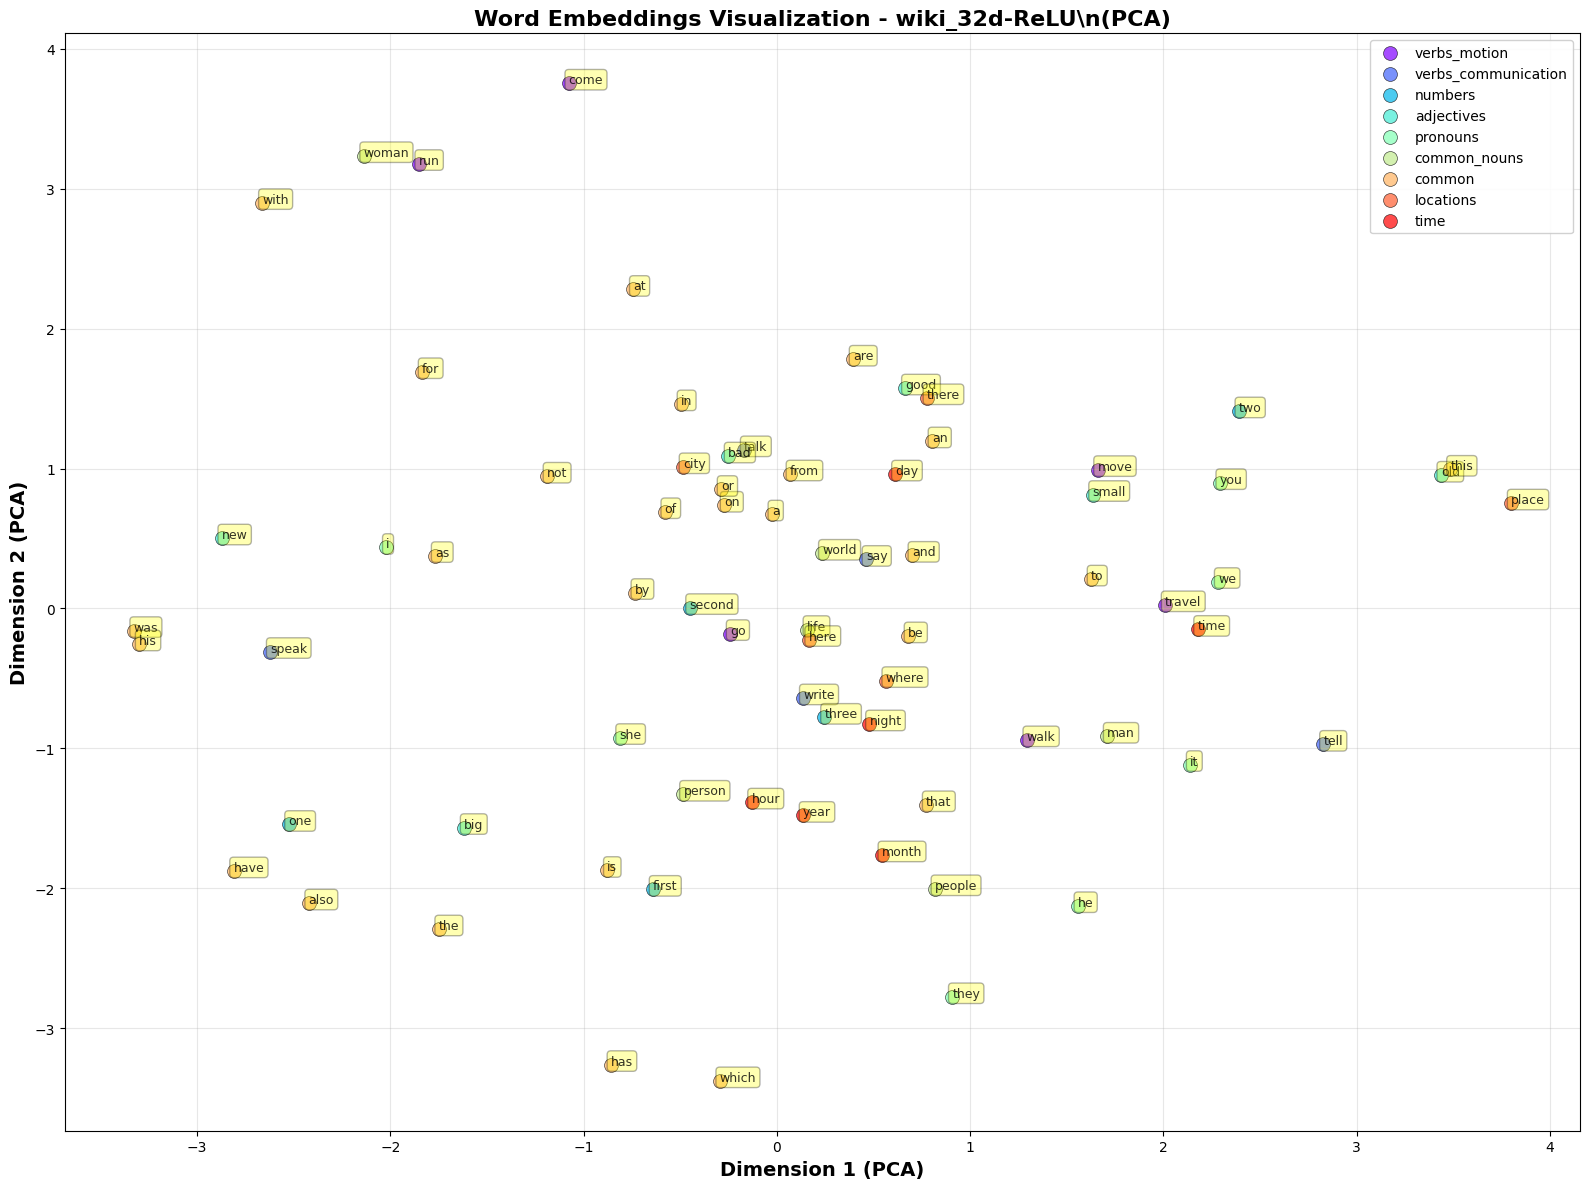

✅ Visualization saved as 'wiki_32d-ReLU_embeddings_pca.png'

Nearest Neighbors Analysis - wiki_32d-ReLU

🔍 Word: 'i'
   Top 5 nearest neighbors:
      1. 'you' (similarity: -0.0648)
      2. 'year' (similarity: -0.1113)
      3. 'write' (similarity: 0.0994)
      4. 'world' (similarity: 0.0237)
      5. 'woman' (similarity: 0.3262)

🔍 Word: 'you'
   Top 5 nearest neighbors:
      1. 'year' (similarity: -0.2962)
      2. 'write' (similarity: 0.0155)
      3. 'world' (similarity: -0.0651)
      4. 'woman' (similarity: -0.0715)
      5. 'with' (similarity: -0.2478)

🔍 Word: 'he'
   Top 5 nearest neighbors:
      1. 'you' (similarity: 0.0618)
      2. 'year' (similarity: 0.1669)
      3. 'write' (similarity: 0.3689)
      4. 'world' (similarity: -0.0872)
      5. 'woman' (similarity: -0.3679)

🔍 Word: 'she'
   Top 5 nearest neighbors:
      1. 'you' (similarity: -0.0864)
      2. 'year' (similarity: 0.2920)
      3. 'write' (similarity: 0.2499)
      4. 'world' (similarity: 0.0404)
      5

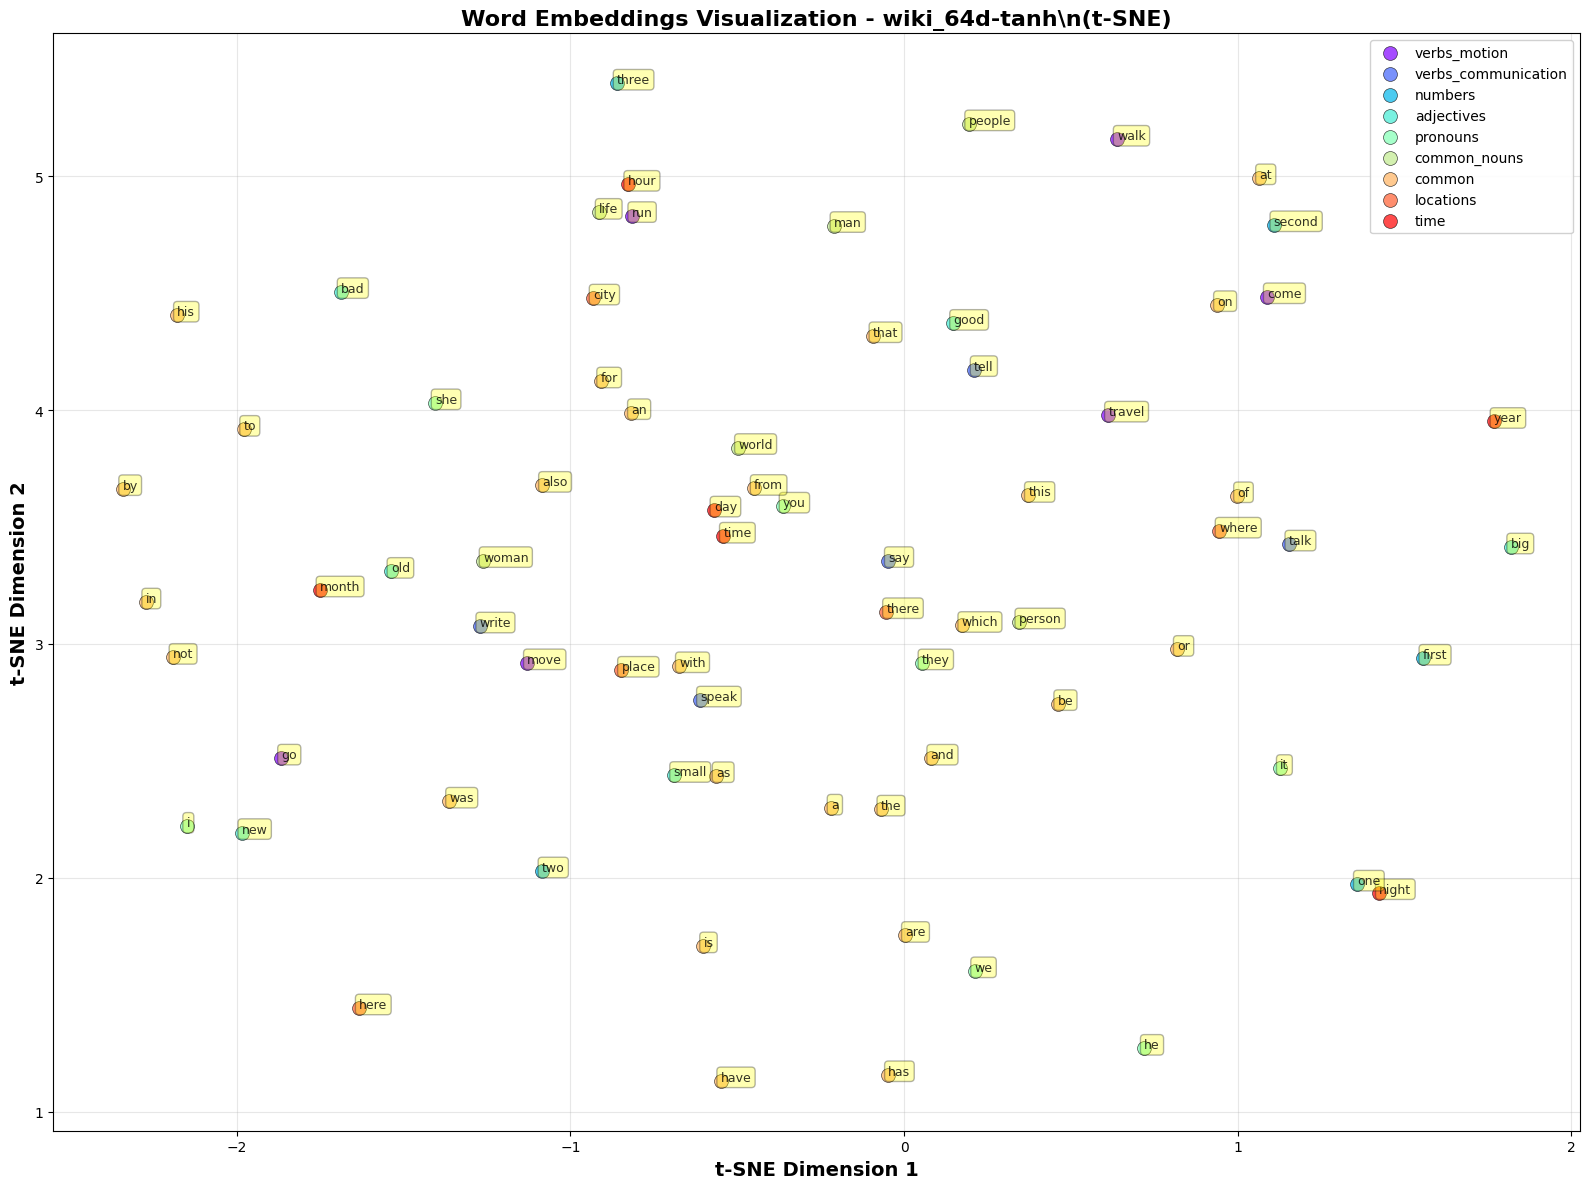

✅ Visualization saved as 'wiki_64d-tanh_embeddings_tsne.png'
Reducing 64D embeddings to 2D using PCA...


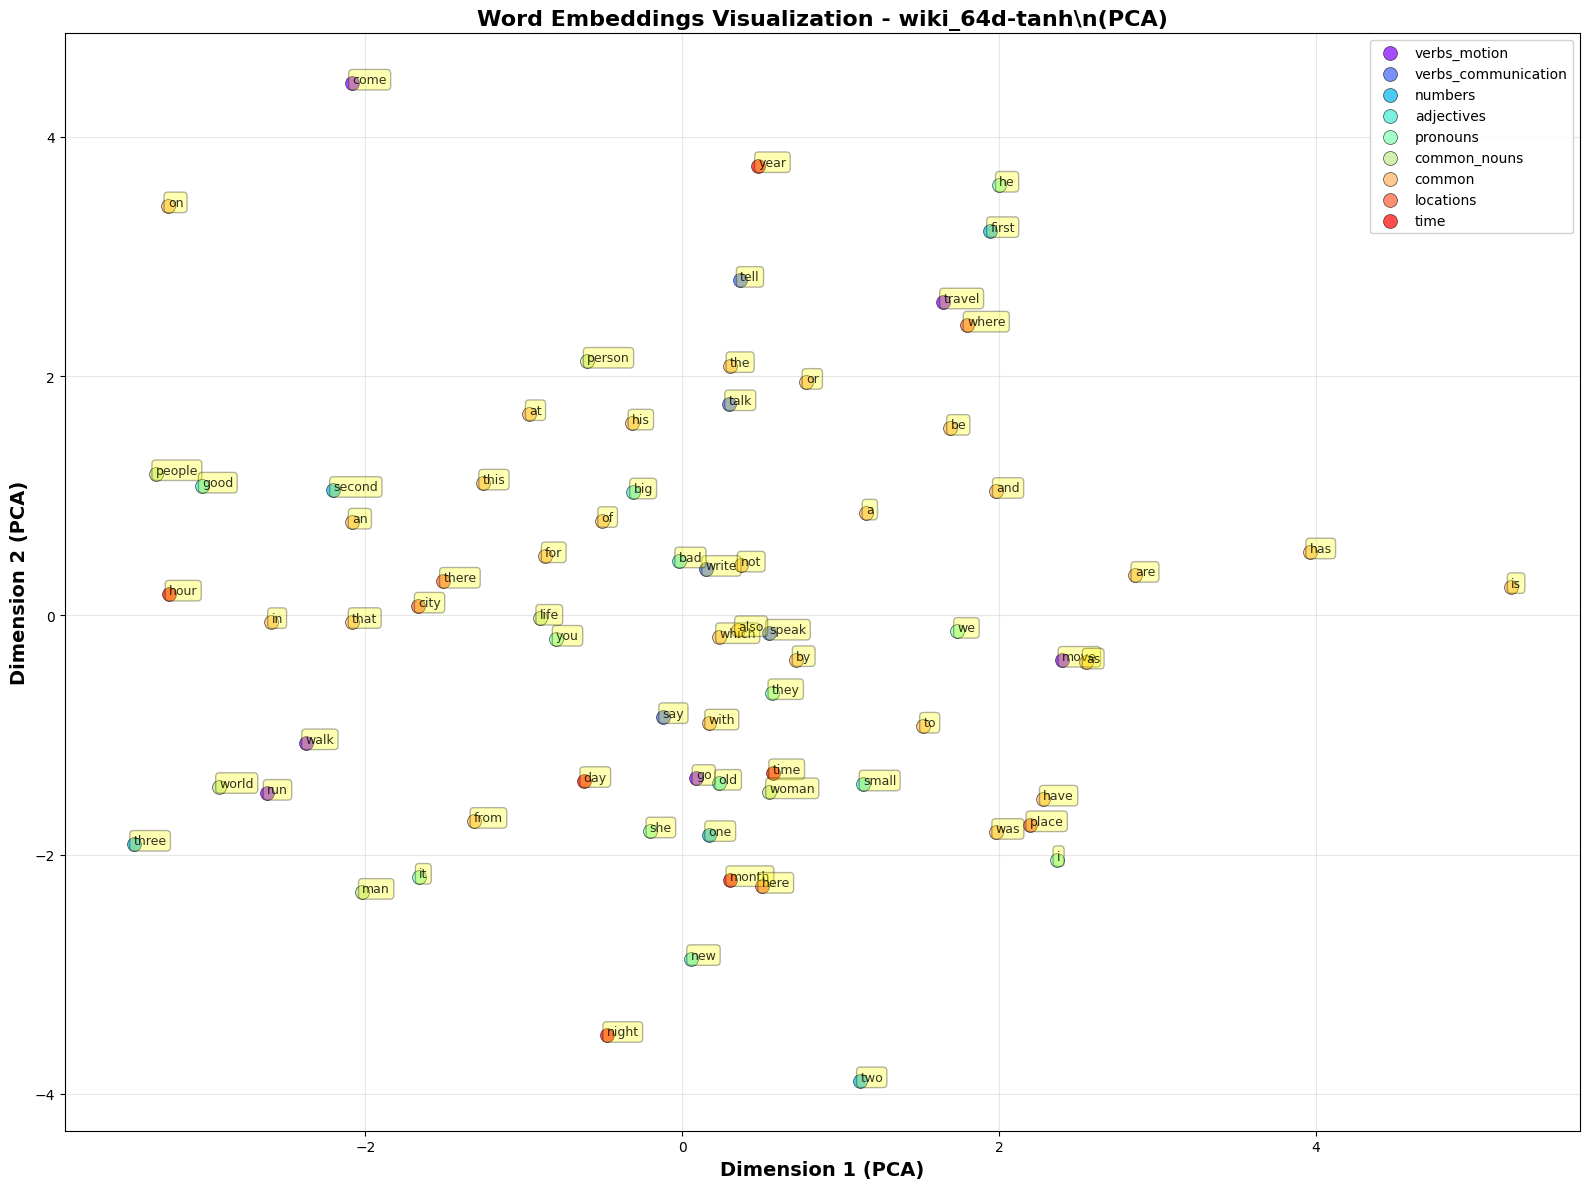

✅ Visualization saved as 'wiki_64d-tanh_embeddings_pca.png'

Nearest Neighbors Analysis - wiki_64d-tanh

🔍 Word: 'i'
   Top 5 nearest neighbors:
      1. 'you' (similarity: 0.1799)
      2. 'year' (similarity: 0.0091)
      3. 'write' (similarity: 0.1629)
      4. 'world' (similarity: 0.1167)
      5. 'woman' (similarity: -0.0206)

🔍 Word: 'you'
   Top 5 nearest neighbors:
      1. 'year' (similarity: 0.1686)
      2. 'write' (similarity: 0.0812)
      3. 'world' (similarity: 0.2678)
      4. 'woman' (similarity: -0.0322)
      5. 'with' (similarity: 0.1114)

🔍 Word: 'he'
   Top 5 nearest neighbors:
      1. 'you' (similarity: -0.0475)
      2. 'year' (similarity: -0.0755)
      3. 'write' (similarity: -0.0353)
      4. 'world' (similarity: -0.1204)
      5. 'woman' (similarity: -0.1244)

🔍 Word: 'she'
   Top 5 nearest neighbors:
      1. 'you' (similarity: -0.1336)
      2. 'year' (similarity: -0.2011)
      3. 'write' (similarity: -0.0672)
      4. 'world' (similarity: 0.0659)
      

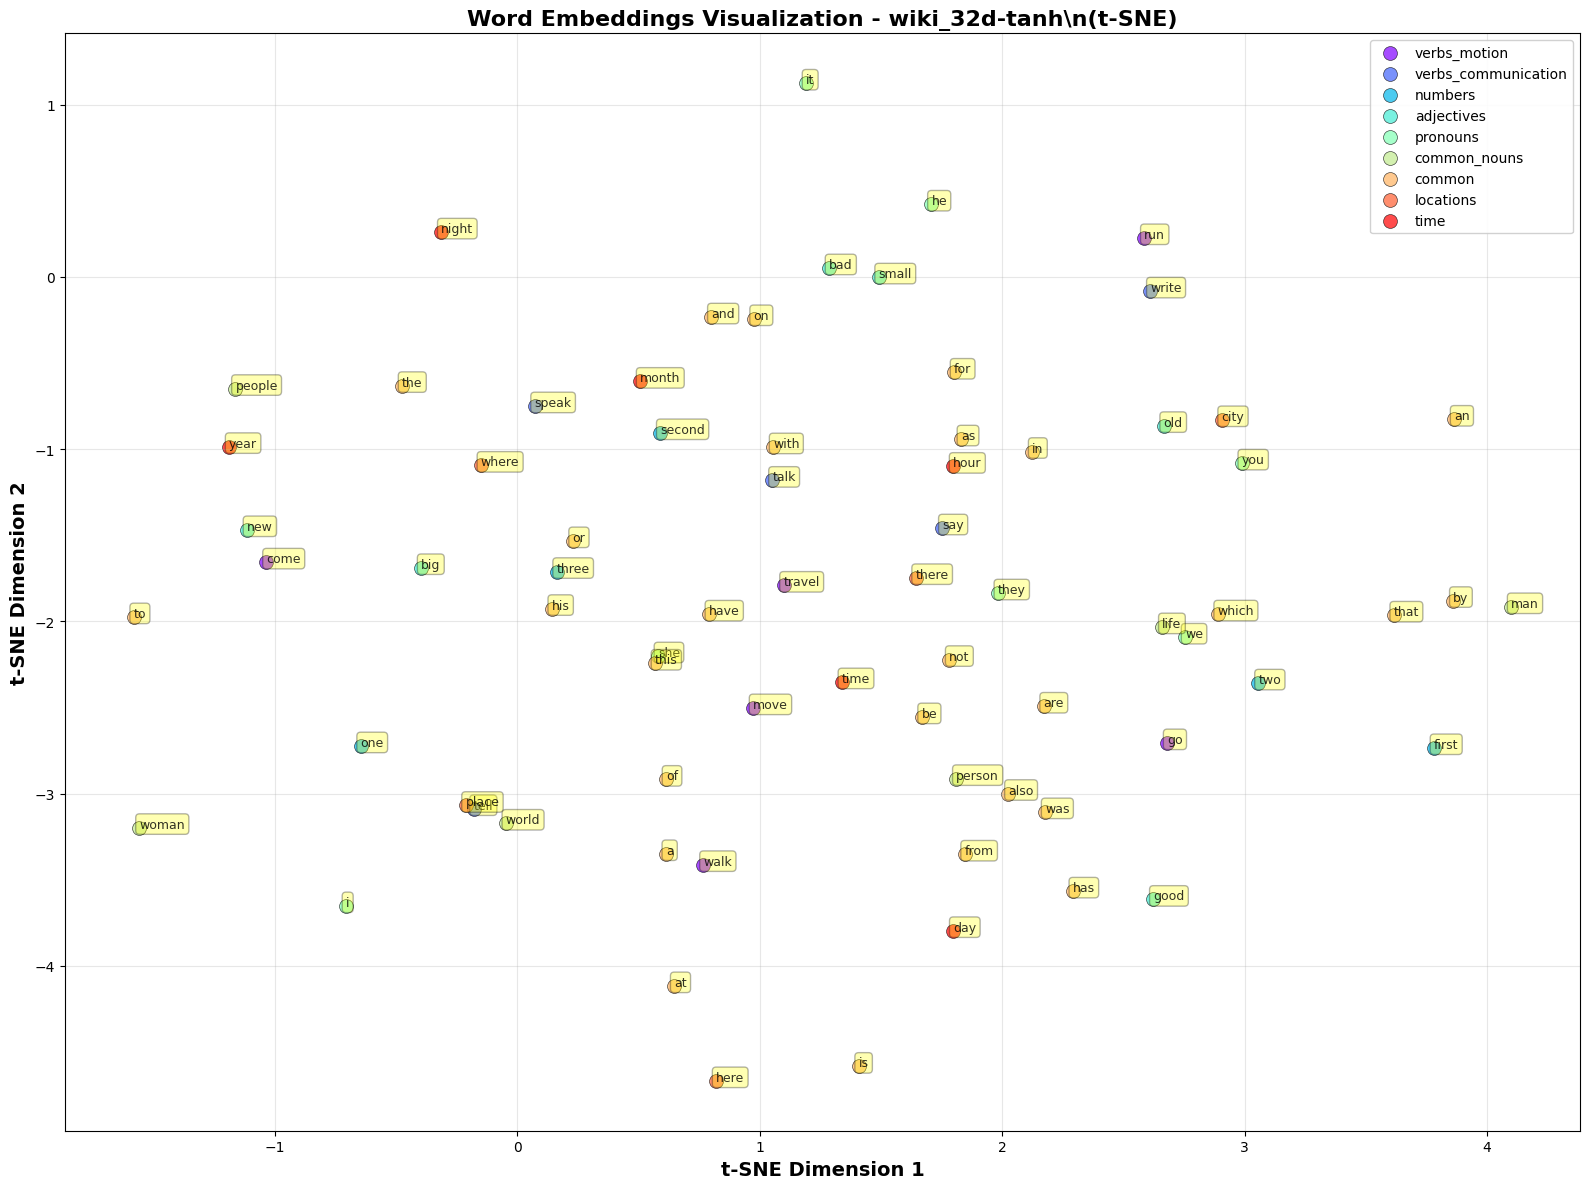

✅ Visualization saved as 'wiki_32d-tanh_embeddings_tsne.png'
Reducing 32D embeddings to 2D using PCA...


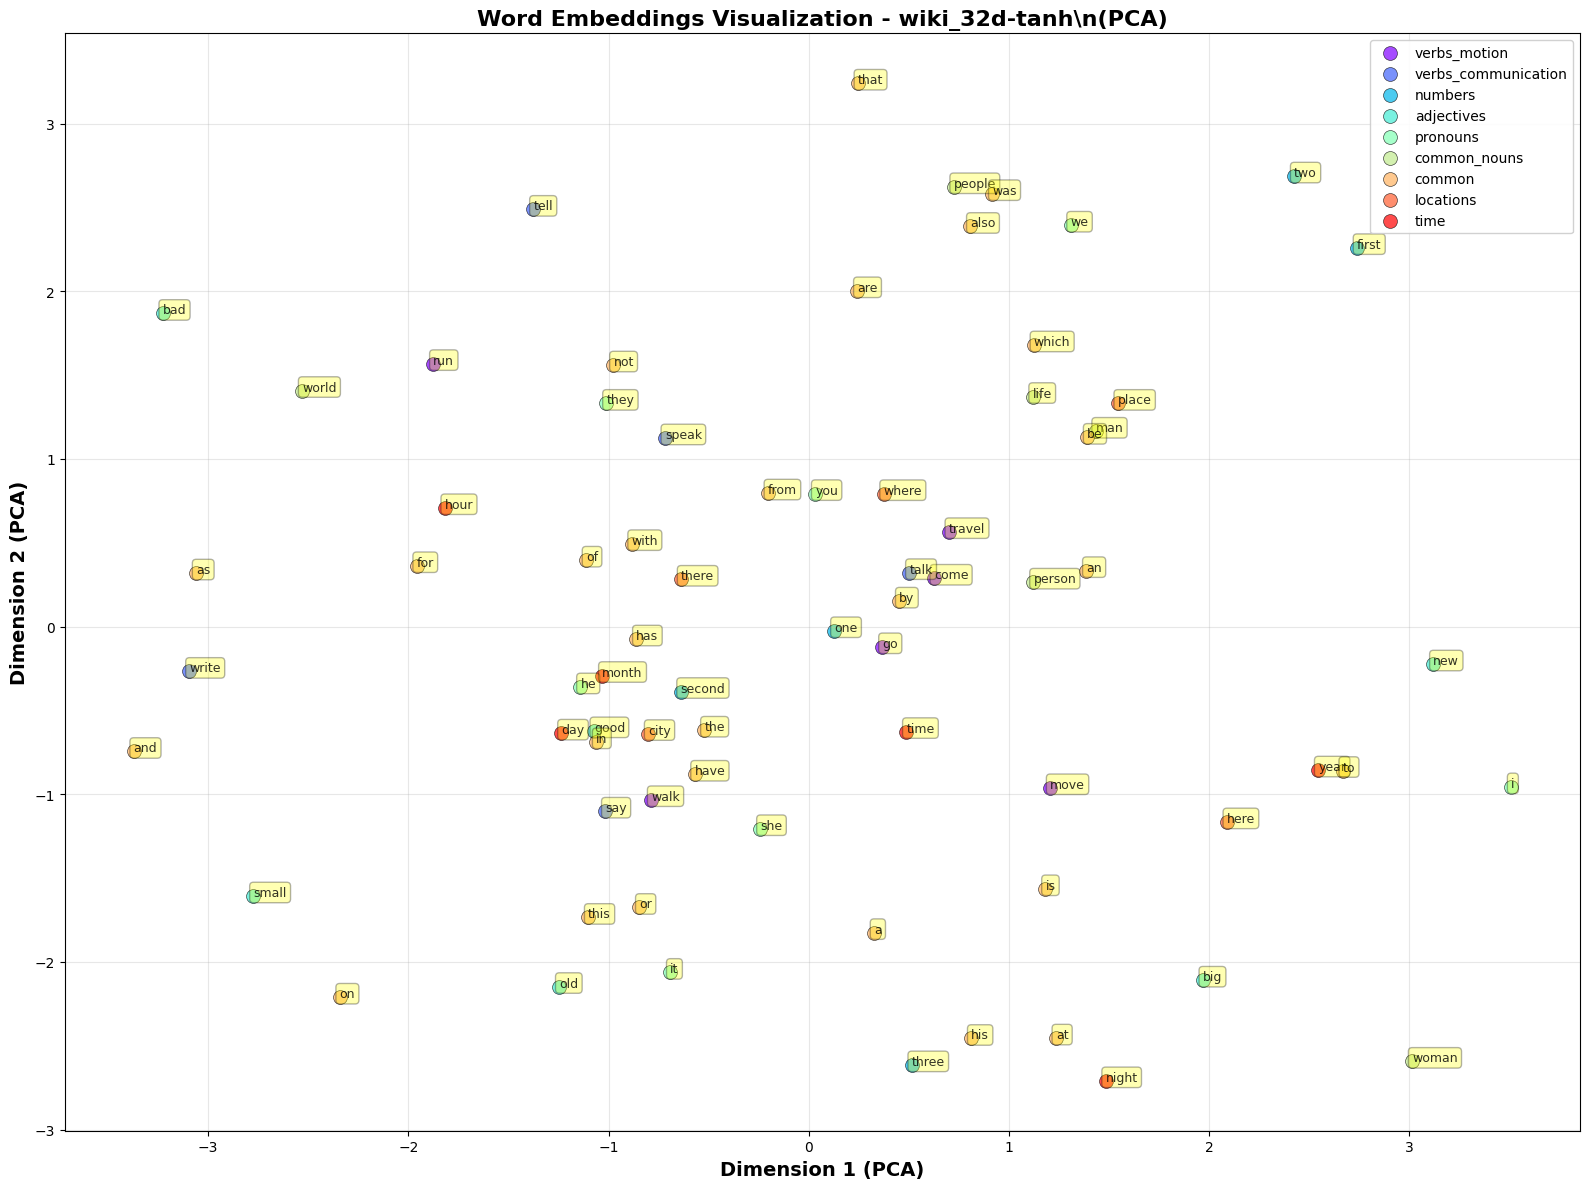

✅ Visualization saved as 'wiki_32d-tanh_embeddings_pca.png'

Nearest Neighbors Analysis - wiki_32d-tanh

🔍 Word: 'i'
   Top 5 nearest neighbors:
      1. 'you' (similarity: 0.0325)
      2. 'year' (similarity: 0.0265)
      3. 'write' (similarity: -0.3143)
      4. 'world' (similarity: 0.0125)
      5. 'woman' (similarity: 0.4091)

🔍 Word: 'you'
   Top 5 nearest neighbors:
      1. 'year' (similarity: 0.0531)
      2. 'write' (similarity: 0.3695)
      3. 'world' (similarity: 0.0571)
      4. 'woman' (similarity: 0.2237)
      5. 'with' (similarity: -0.0016)

🔍 Word: 'he'
   Top 5 nearest neighbors:
      1. 'you' (similarity: 0.0495)
      2. 'year' (similarity: 0.0976)
      3. 'write' (similarity: -0.0117)
      4. 'world' (similarity: 0.2079)
      5. 'woman' (similarity: 0.2174)

🔍 Word: 'she'
   Top 5 nearest neighbors:
      1. 'you' (similarity: 0.0893)
      2. 'year' (similarity: 0.1309)
      3. 'write' (similarity: -0.2621)
      4. 'world' (similarity: 0.3098)
      5. 'wo

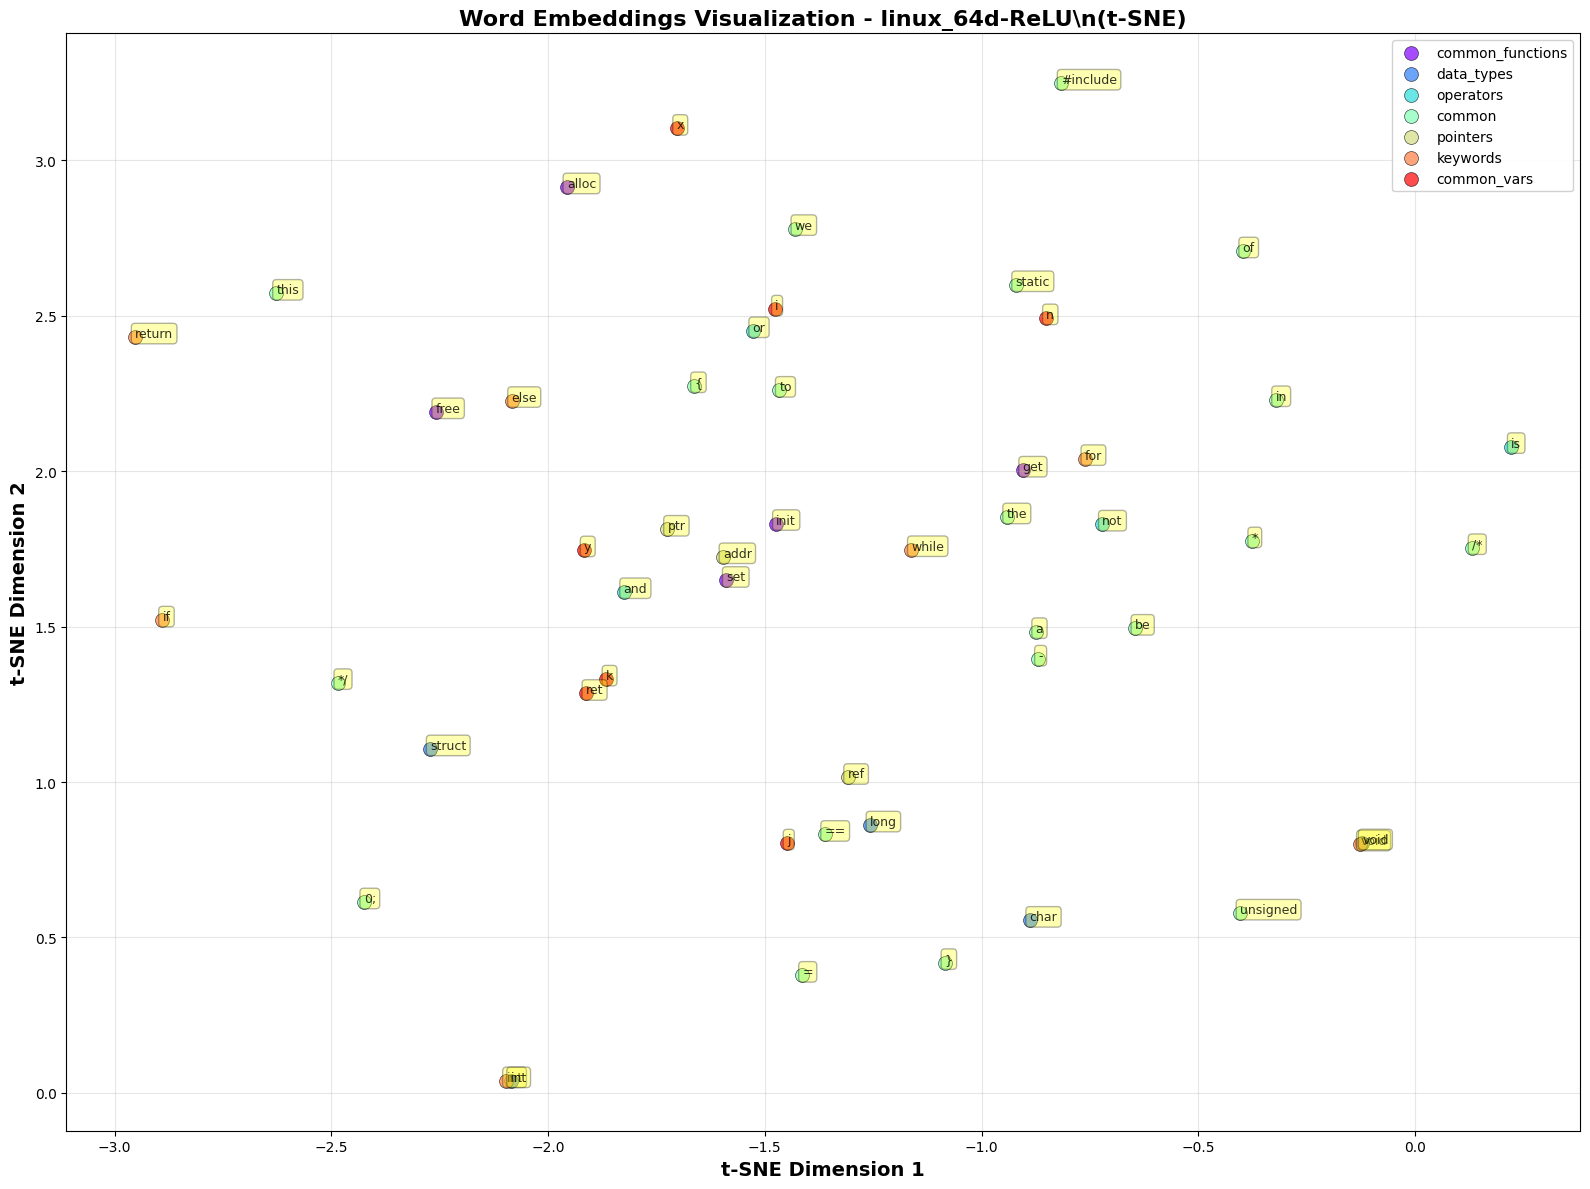

✅ Visualization saved as 'linux_64d-ReLU_embeddings_tsne.png'
Reducing 64D embeddings to 2D using PCA...


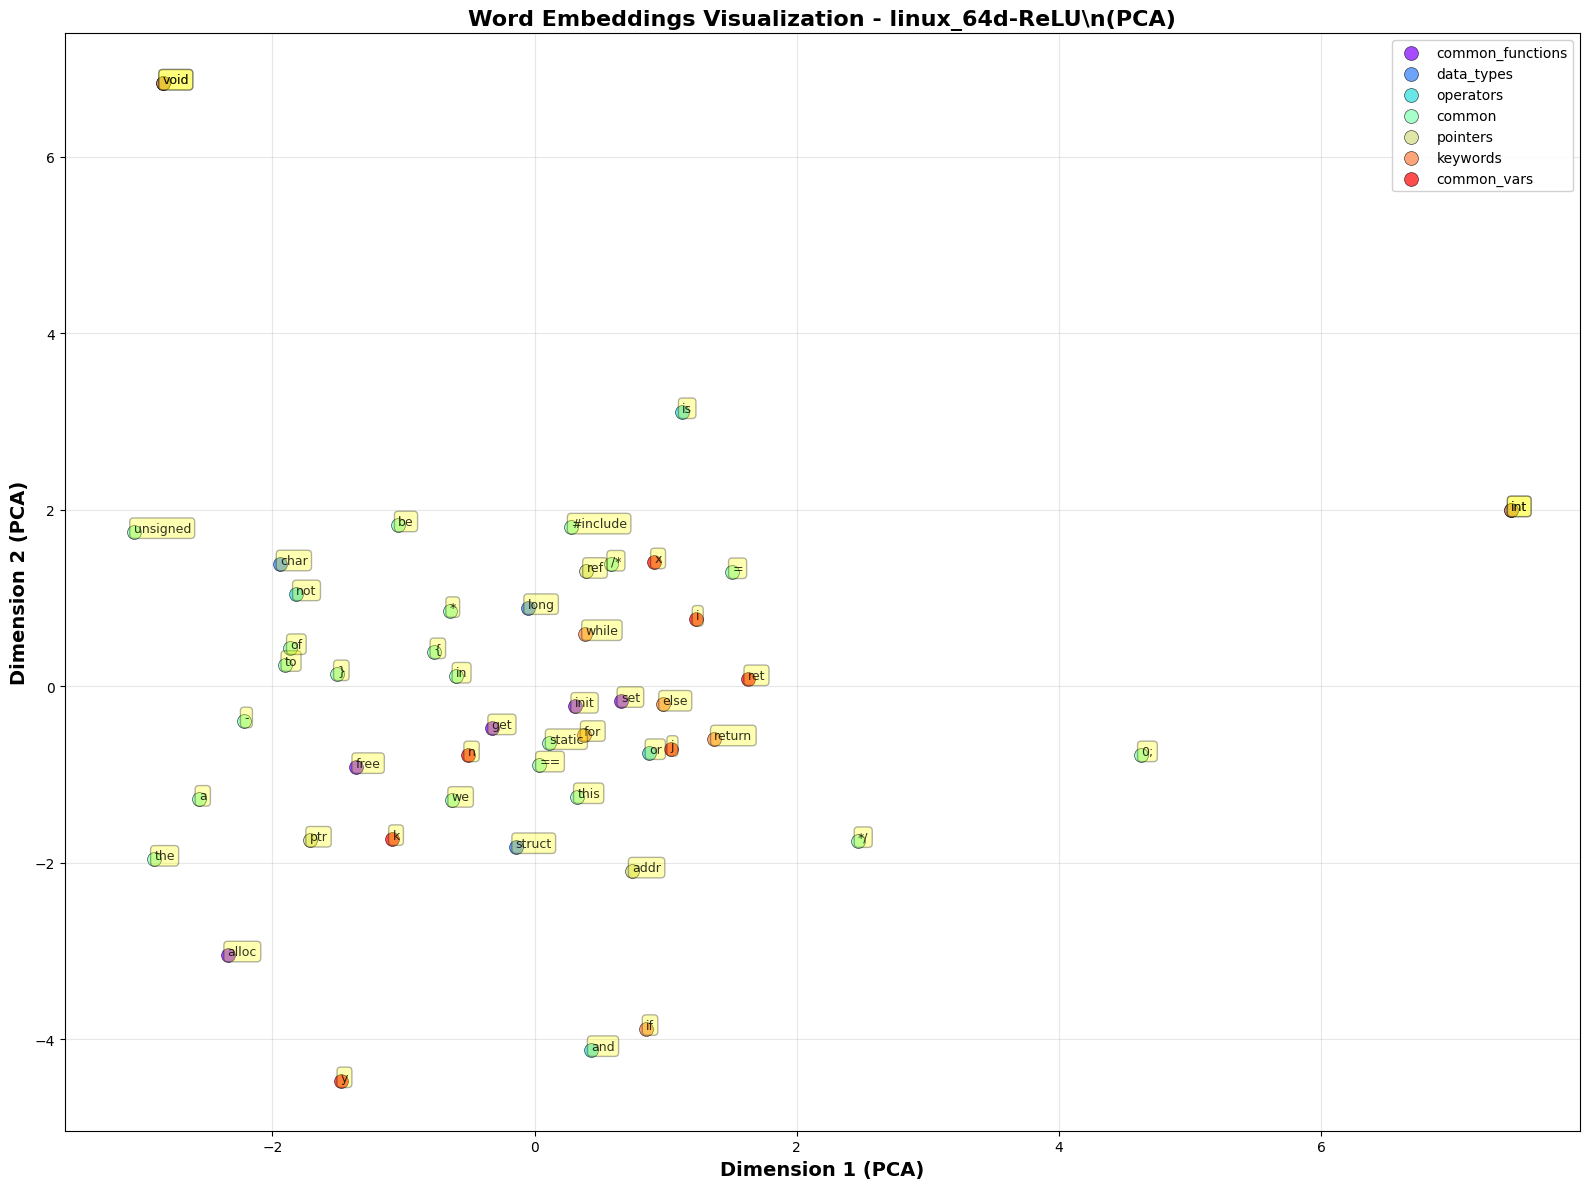

✅ Visualization saved as 'linux_64d-ReLU_embeddings_pca.png'

Nearest Neighbors Analysis - linux_64d-ReLU

🔍 Word: 'if'
   Top 5 nearest neighbors:
      1. '}' (similarity: 0.1701)
      2. '{' (similarity: 0.0122)
      3. 'y' (similarity: 0.1549)
      4. 'x' (similarity: -0.1224)
      5. 'while' (similarity: 0.1566)

🔍 Word: 'else'
   Top 5 nearest neighbors:
      1. '}' (similarity: -0.0424)
      2. '{' (similarity: 0.2698)
      3. 'y' (similarity: 0.0457)
      4. 'x' (similarity: 0.1213)
      5. 'while' (similarity: -0.0359)

🔍 Word: 'for'
   Top 5 nearest neighbors:
      1. '}' (similarity: -0.0296)
      2. '{' (similarity: -0.0335)
      3. 'y' (similarity: -0.0751)
      4. 'x' (similarity: -0.0898)
      5. 'while' (similarity: 0.2262)

🔍 Word: 'while'
   Top 5 nearest neighbors:
      1. '}' (similarity: 0.0854)
      2. '{' (similarity: 0.1479)
      3. 'y' (similarity: 0.0842)
      4. 'x' (similarity: -0.0348)
      5. 'we' (similarity: -0.0810)

🔍 Word: 'return'


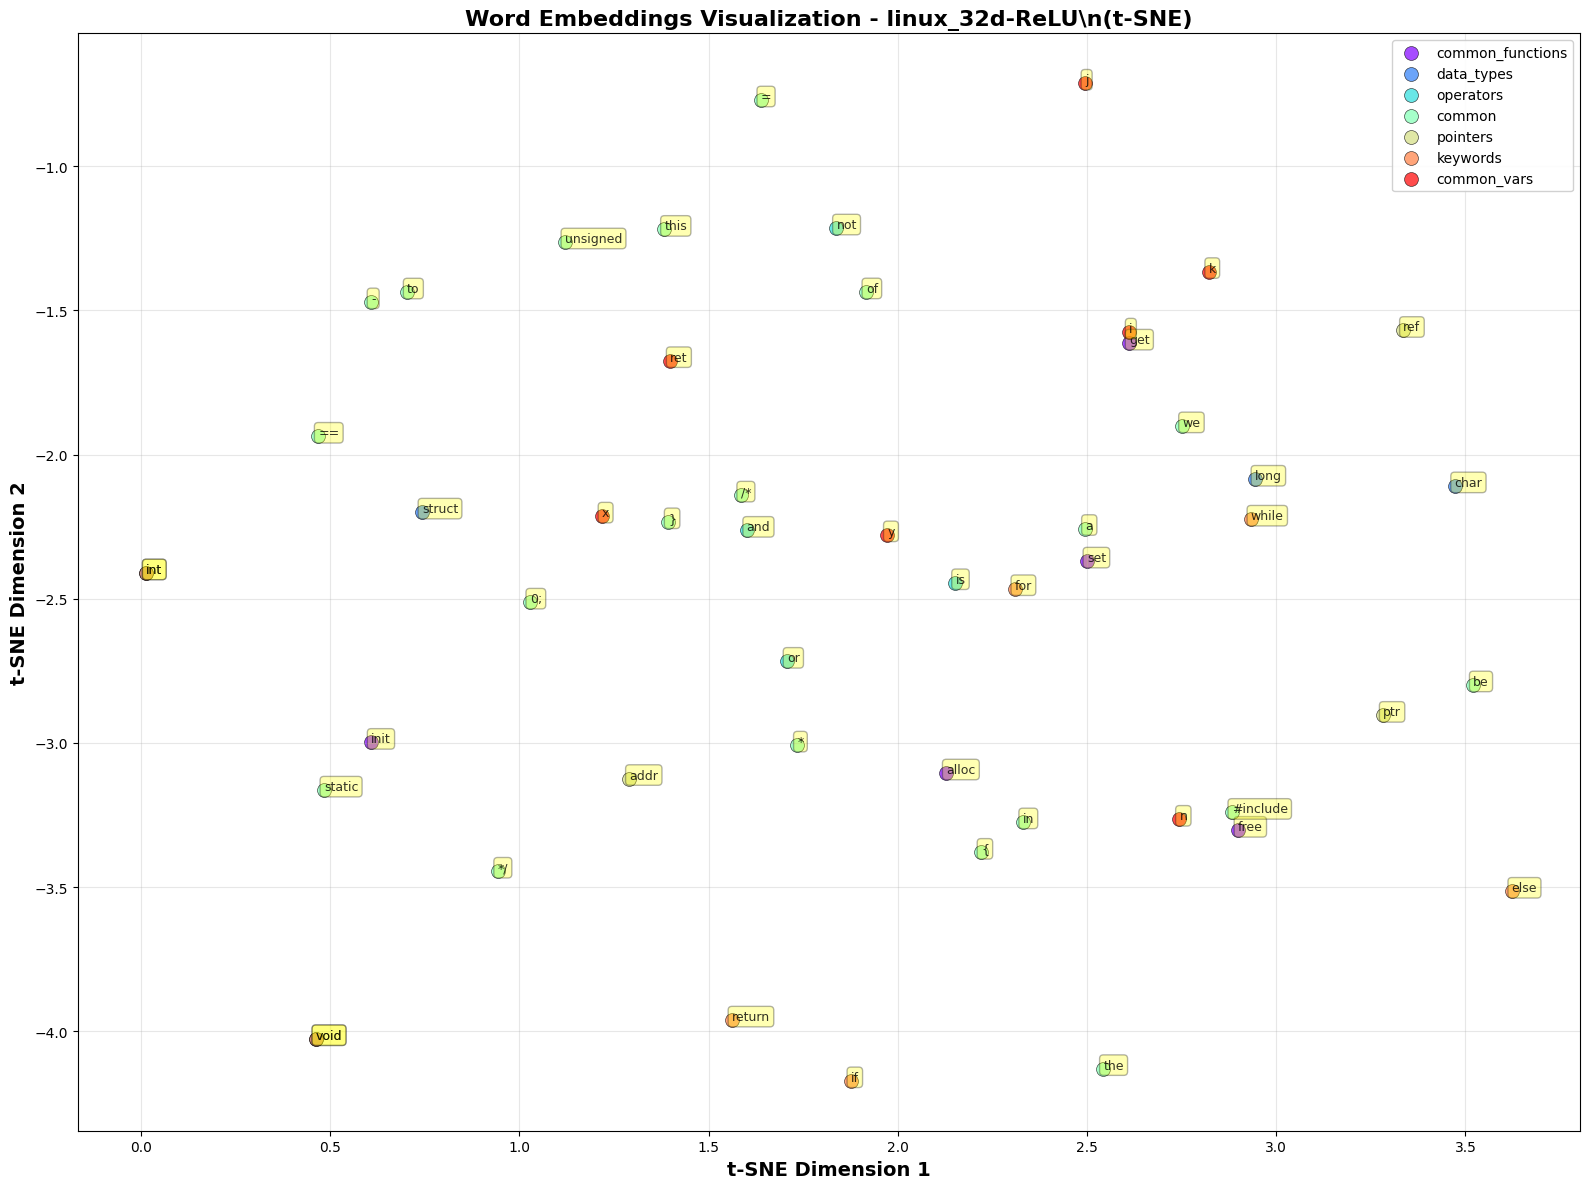

✅ Visualization saved as 'linux_32d-ReLU_embeddings_tsne.png'
Reducing 32D embeddings to 2D using PCA...


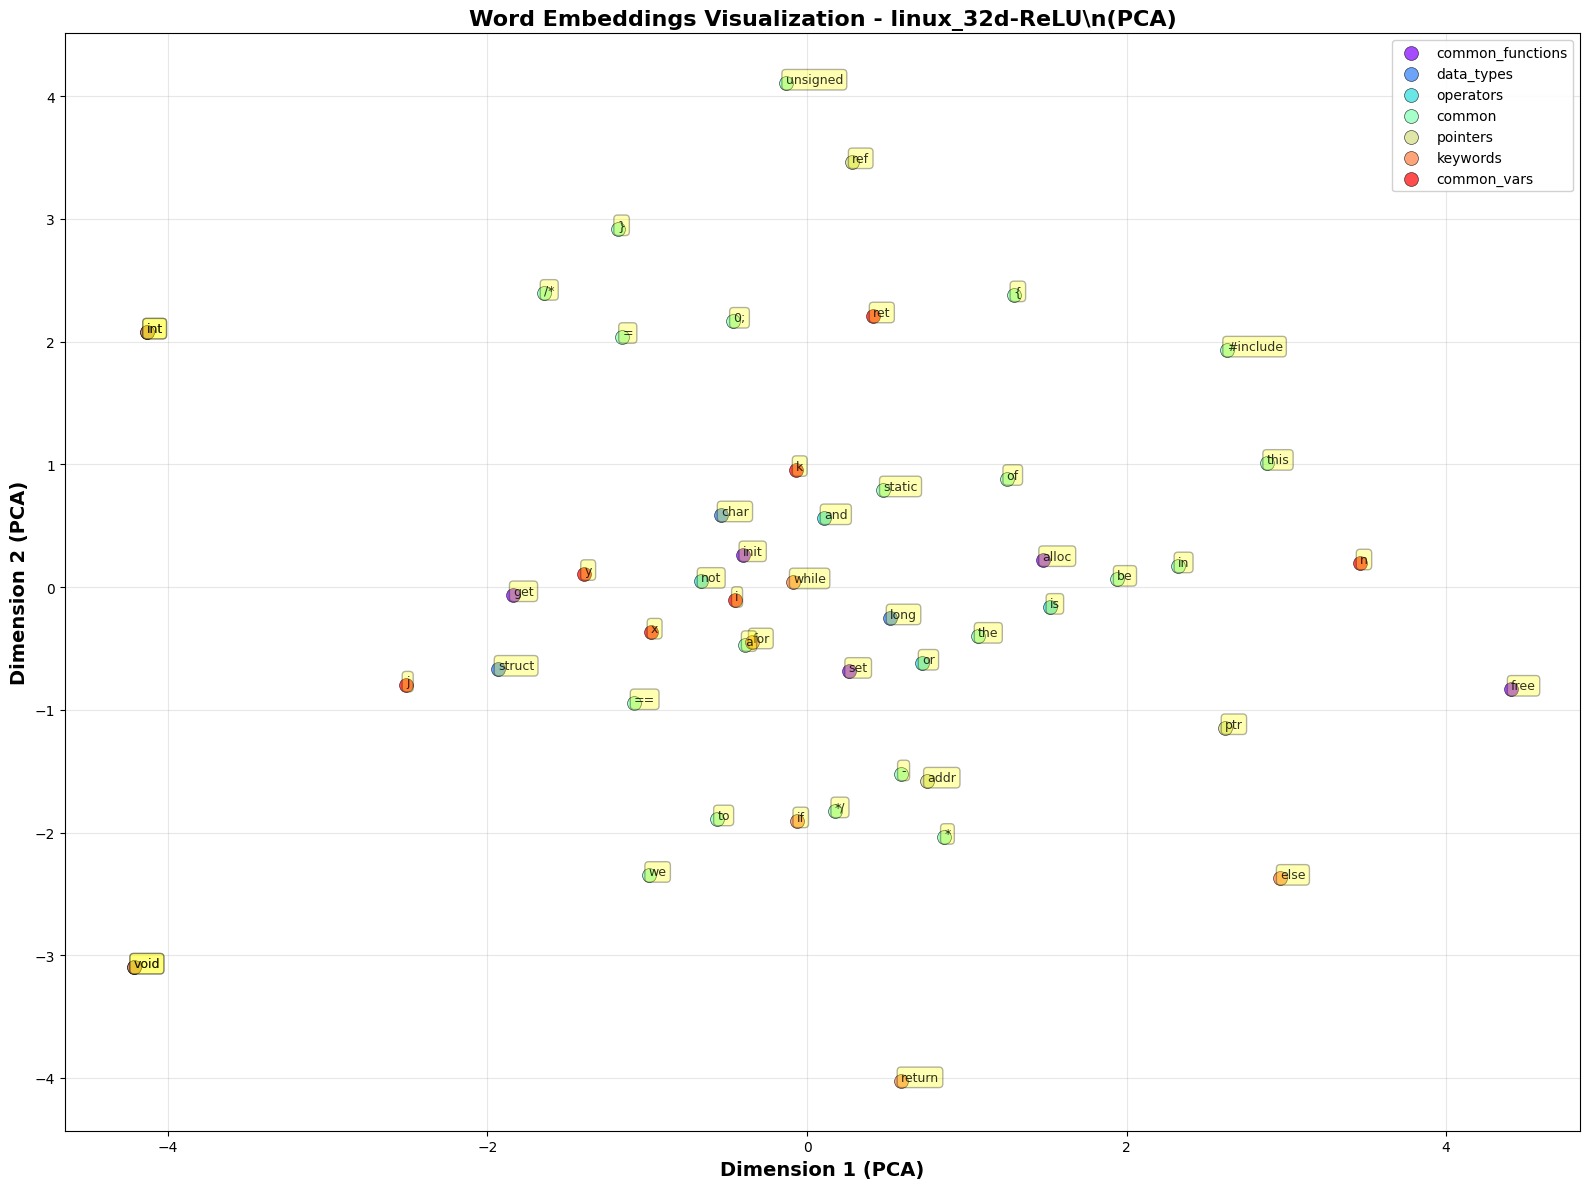

✅ Visualization saved as 'linux_32d-ReLU_embeddings_pca.png'

Nearest Neighbors Analysis - linux_32d-ReLU

🔍 Word: 'if'
   Top 5 nearest neighbors:
      1. '}' (similarity: 0.0245)
      2. '{' (similarity: -0.2331)
      3. 'y' (similarity: 0.2300)
      4. 'x' (similarity: -0.1130)
      5. 'while' (similarity: 0.1197)

🔍 Word: 'else'
   Top 5 nearest neighbors:
      1. '}' (similarity: -0.2527)
      2. '{' (similarity: -0.0389)
      3. 'y' (similarity: -0.3872)
      4. 'x' (similarity: -0.1910)
      5. 'while' (similarity: -0.0047)

🔍 Word: 'for'
   Top 5 nearest neighbors:
      1. '}' (similarity: 0.1082)
      2. '{' (similarity: 0.0530)
      3. 'y' (similarity: 0.2305)
      4. 'x' (similarity: 0.0515)
      5. 'while' (similarity: 0.1112)

🔍 Word: 'while'
   Top 5 nearest neighbors:
      1. '}' (similarity: -0.1999)
      2. '{' (similarity: 0.1489)
      3. 'y' (similarity: -0.1505)
      4. 'x' (similarity: -0.1197)
      5. 'we' (similarity: 0.1501)

🔍 Word: 'return'

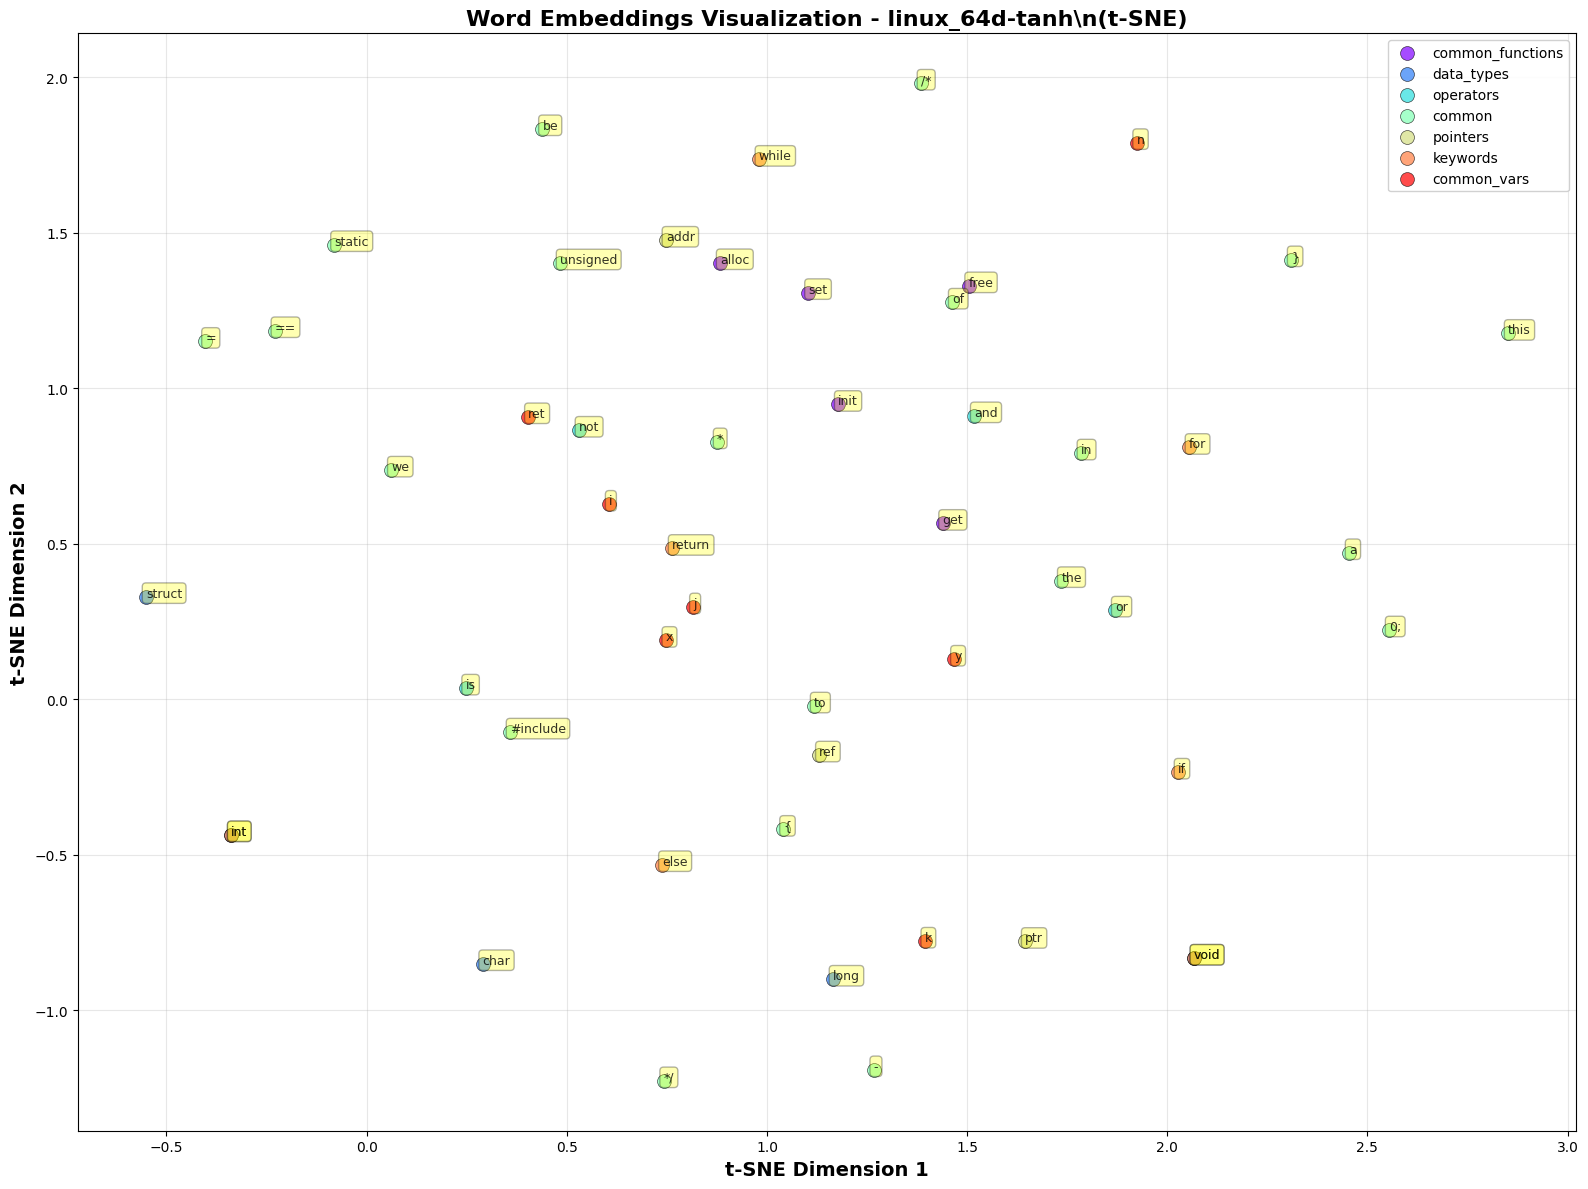

✅ Visualization saved as 'linux_64d-tanh_embeddings_tsne.png'
Reducing 64D embeddings to 2D using PCA...


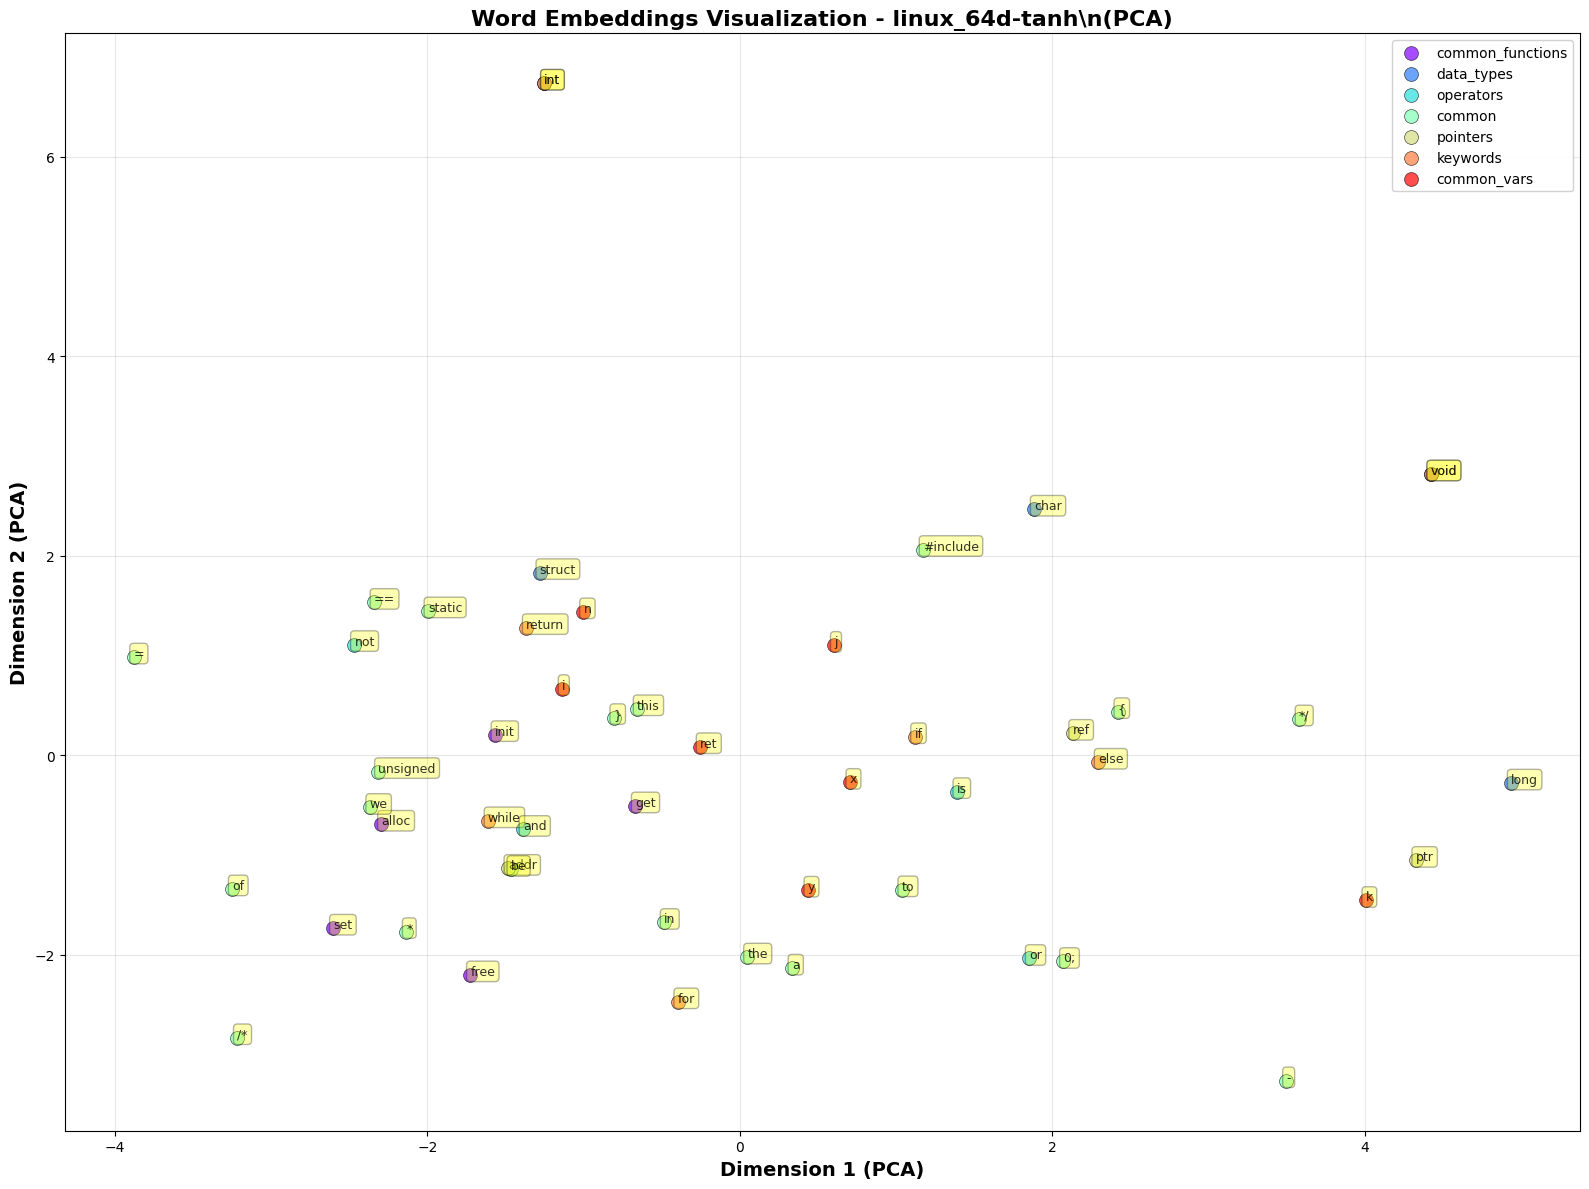

✅ Visualization saved as 'linux_64d-tanh_embeddings_pca.png'

Nearest Neighbors Analysis - linux_64d-tanh

🔍 Word: 'if'
   Top 5 nearest neighbors:
      1. '}' (similarity: 0.0886)
      2. '{' (similarity: -0.0099)
      3. 'y' (similarity: 0.1041)
      4. 'x' (similarity: -0.0924)
      5. 'while' (similarity: 0.2241)

🔍 Word: 'else'
   Top 5 nearest neighbors:
      1. '}' (similarity: 0.0632)
      2. '{' (similarity: 0.0196)
      3. 'y' (similarity: 0.0658)
      4. 'x' (similarity: -0.0078)
      5. 'while' (similarity: -0.0691)

🔍 Word: 'for'
   Top 5 nearest neighbors:
      1. '}' (similarity: -0.1789)
      2. '{' (similarity: -0.0173)
      3. 'y' (similarity: -0.0006)
      4. 'x' (similarity: -0.1074)
      5. 'while' (similarity: 0.0352)

🔍 Word: 'while'
   Top 5 nearest neighbors:
      1. '}' (similarity: -0.0070)
      2. '{' (similarity: -0.0493)
      3. 'y' (similarity: -0.1875)
      4. 'x' (similarity: 0.0484)
      5. 'we' (similarity: 0.1802)

🔍 Word: 'return

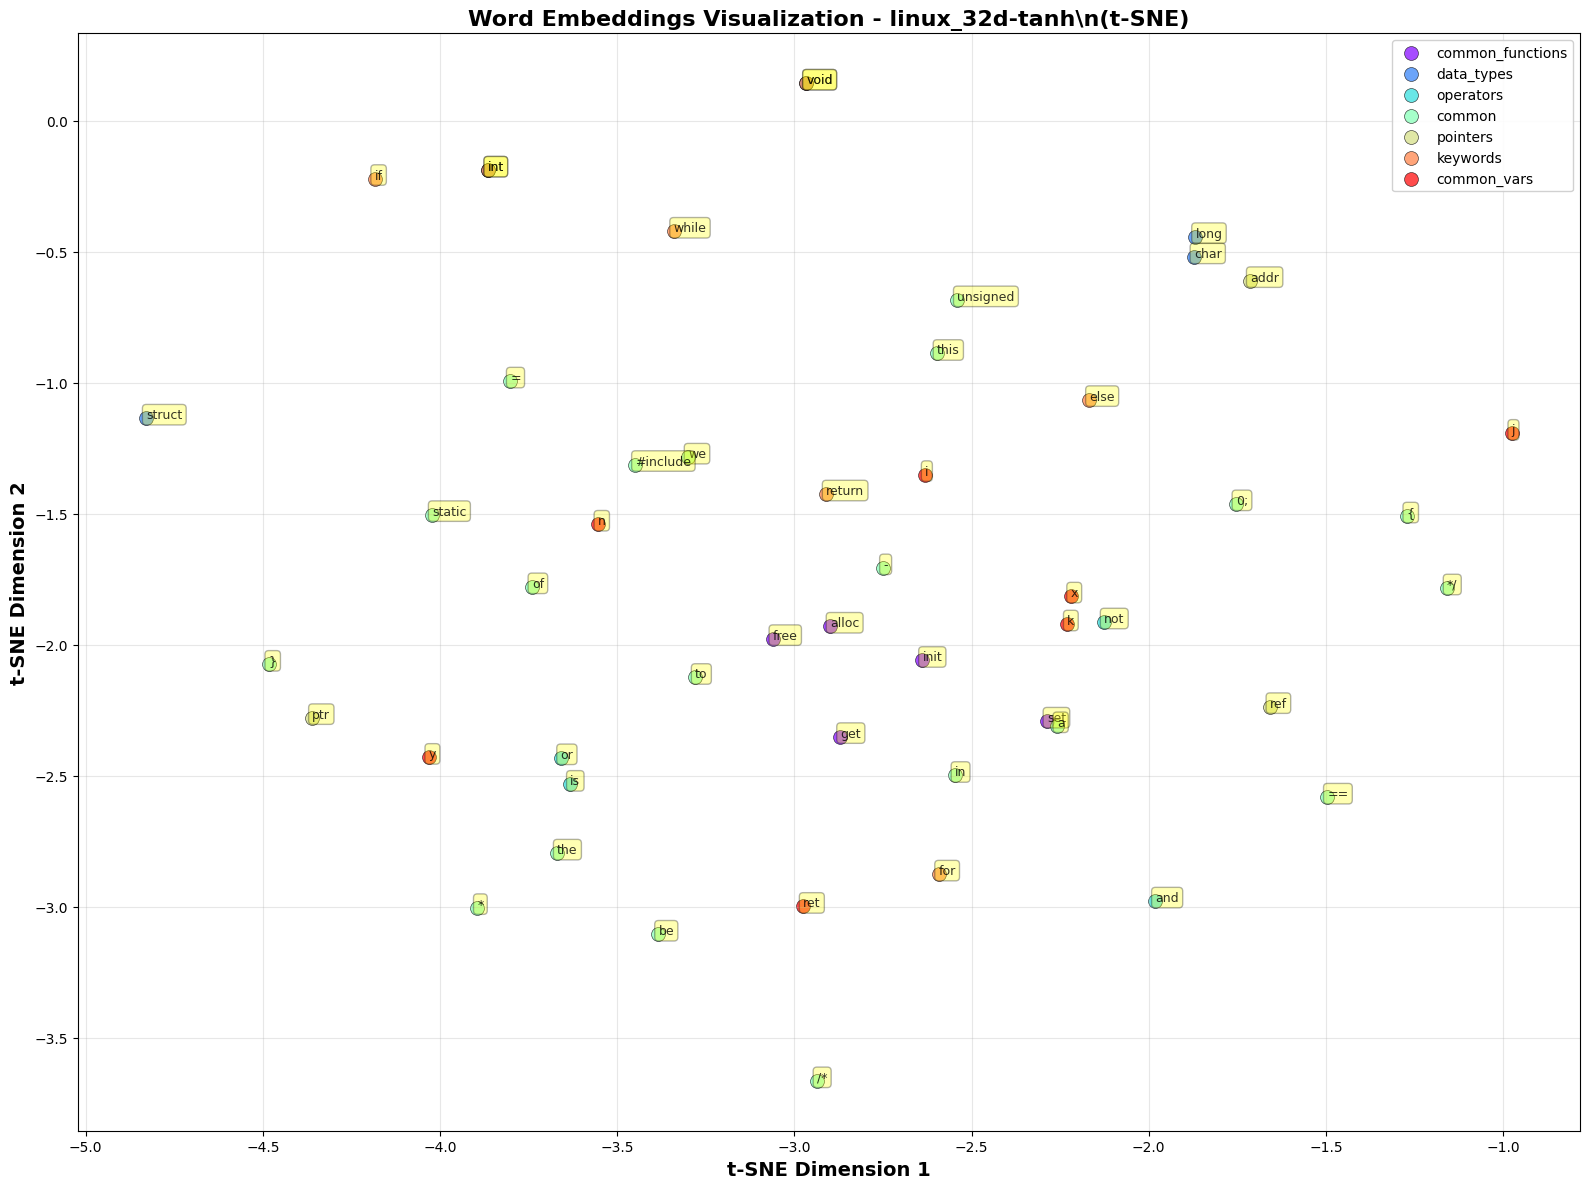

✅ Visualization saved as 'linux_32d-tanh_embeddings_tsne.png'
Reducing 32D embeddings to 2D using PCA...


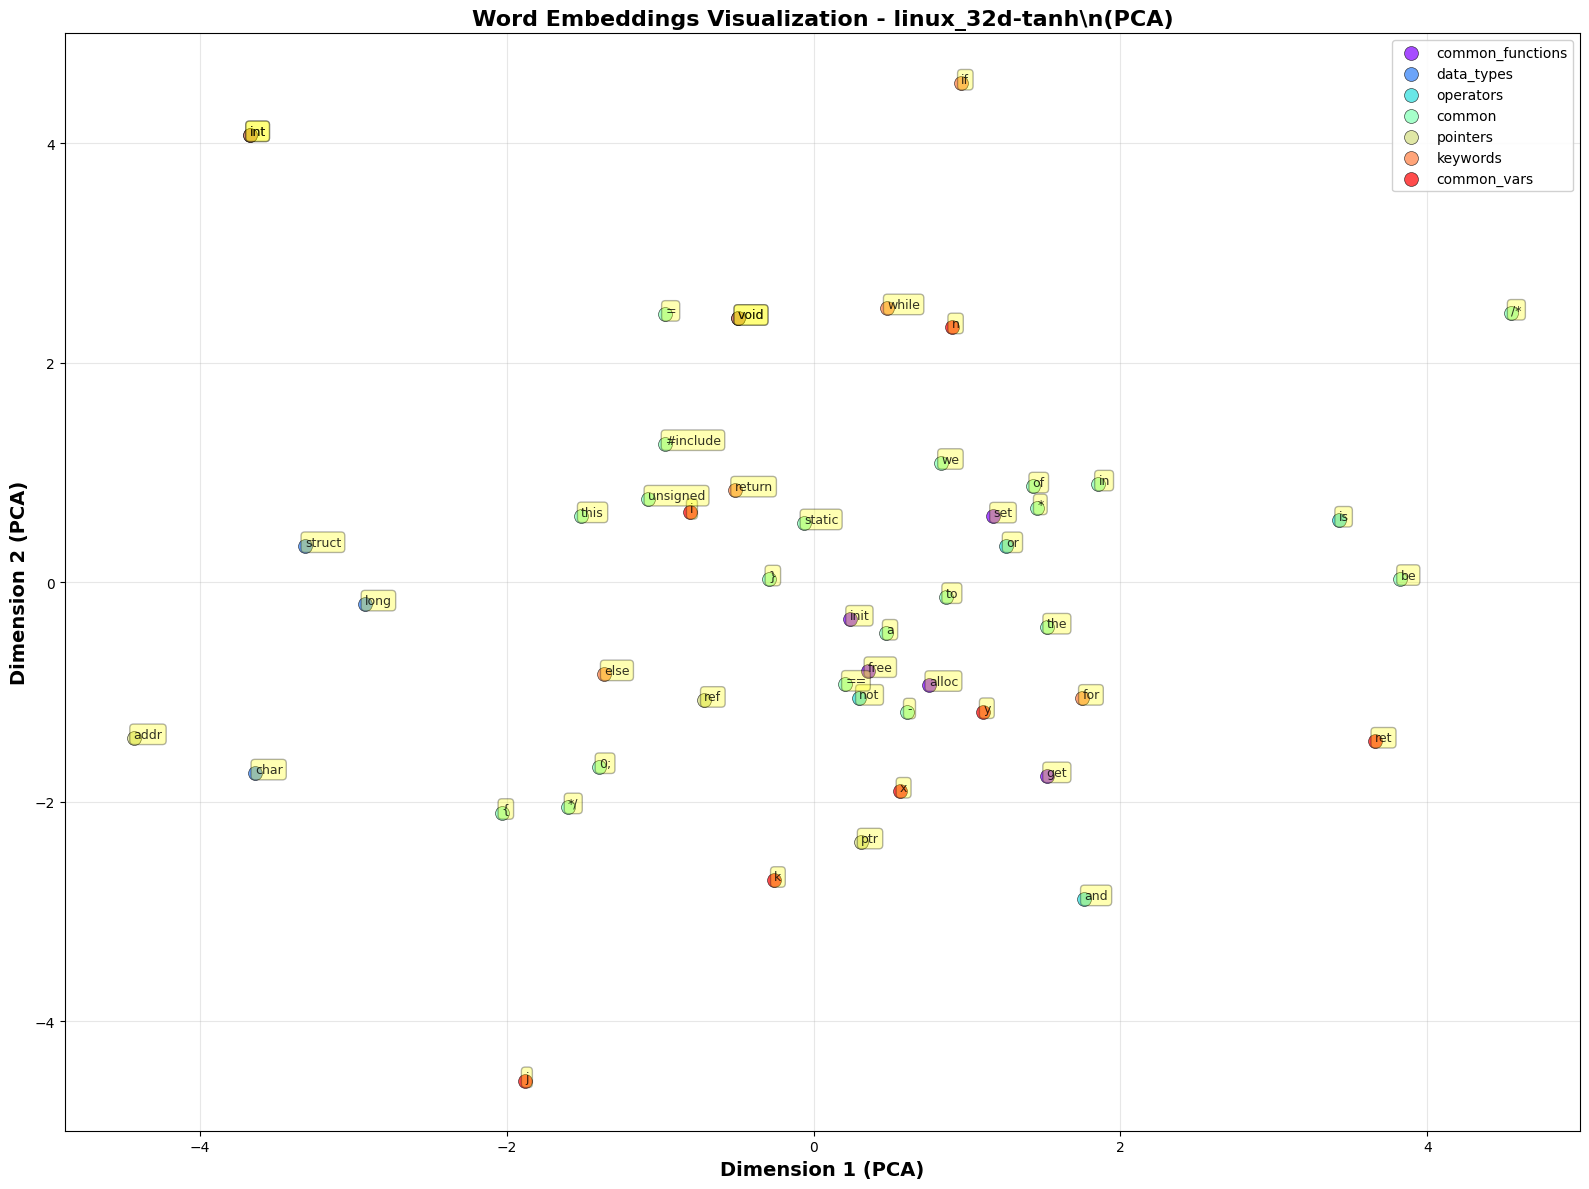

✅ Visualization saved as 'linux_32d-tanh_embeddings_pca.png'

Nearest Neighbors Analysis - linux_32d-tanh

🔍 Word: 'if'
   Top 5 nearest neighbors:
      1. '}' (similarity: 0.1640)
      2. '{' (similarity: -0.1611)
      3. 'y' (similarity: 0.0202)
      4. 'x' (similarity: -0.1398)
      5. 'while' (similarity: 0.4086)

🔍 Word: 'else'
   Top 5 nearest neighbors:
      1. '}' (similarity: 0.1113)
      2. '{' (similarity: 0.2516)
      3. 'y' (similarity: -0.2346)
      4. 'x' (similarity: 0.2006)
      5. 'while' (similarity: -0.0756)

🔍 Word: 'for'
   Top 5 nearest neighbors:
      1. '}' (similarity: -0.1126)
      2. '{' (similarity: -0.1116)
      3. 'y' (similarity: 0.2263)
      4. 'x' (similarity: 0.0120)
      5. 'while' (similarity: -0.1702)

🔍 Word: 'while'
   Top 5 nearest neighbors:
      1. '}' (similarity: -0.0843)
      2. '{' (similarity: -0.2033)
      3. 'y' (similarity: -0.0228)
      4. 'x' (similarity: -0.0078)
      5. 'we' (similarity: 0.0490)

🔍 Word: 'return

In [10]:
print("\n" + "="*80)
print("GENERATING EMBEDDING VISUALIZATIONS FOR ALL MODELS")
print("="*80)

visualization_results = {}

for model_name, model_data in all_models.items():
    print(f"\nProcessing: {model_name}")
    
    model = load_model_if_needed(model_data, model_name)
    embeddings = extract_embeddings(model)
    word_to_idx, idx_to_word, dataset_type = get_vocab_maps(model_name)

    
    # Load word counts
    if dataset_type == 'wikipedia':
        with open('wikipedia_processed.pkl', 'rb') as f:
            data = pickle.load(f)
            word_counts = data['word_counts']
    else:
        with open('linux_processed.pkl', 'rb') as f:
            data = pickle.load(f)
            word_counts = data['word_counts']
    
    # Select interesting words
    selected_words, selected_labels = select_interesting_words(
        word_to_idx, idx_to_word, word_counts, dataset_type
    )
    
    print(f"Selected {len(selected_words)} words for visualization")
    
    # Generate t-SNE visualization
    embeddings_tsne = visualize_embeddings_tsne(
        embeddings, selected_words, selected_labels, 
        idx_to_word, word_to_idx, model_name
    )
    
    # Generate PCA visualization
    embeddings_pca = visualize_embeddings_2d(
        embeddings, selected_words, selected_labels,
        idx_to_word, word_to_idx, model_name
    )
    
    # Analyze nearest neighbors
    analyze_embedding_distances(
        embeddings, selected_words, word_to_idx, model_name, top_k=5
    )
    
    # Store results
    visualization_results[model_name] = {
        'embeddings_tsne': embeddings_tsne,
        'embeddings_pca': embeddings_pca,
        'selected_words': selected_words,
        'selected_labels': selected_labels
    }

print("\n✅ All visualizations complete!")


## Observations and Analysis

In [11]:
print("\n" + "="*80)
print("EMBEDDING ANALYSIS: KEY OBSERVATIONS")
print("="*80)

print("""
## Expected Observations:

### Natural Language (Wikipedia) Models:
1. **Semantic Clustering**: Words with similar meanings should cluster together
   - Pronouns (I, you, he, she) should form a cluster
   - Verbs of motion (run, walk, move) should be nearby
   - Time-related words (day, night, year) should group together

2. **Syntactic Patterns**: Words with similar grammatical roles cluster
   - Adjectives cluster separately from nouns
   - Verbs group together based on tense/aspect

3. **Antonyms**: Often appear close together (good/bad, big/small)
   because they appear in similar contexts

4. **Embedding Dimension Effect**:
   - 64D embeddings: More capacity to capture nuanced relationships
   - 32D embeddings: May show simpler, broader clusters

5. **Activation Function Effect**:
   - ReLU: May create more separated, distinct clusters
   - Tanh: Often produces more distributed, overlapping representations

### Structured Code (Linux Kernel) Models:
1. **Syntactic Grouping**: Code tokens cluster by syntax role
   - Keywords (if, else, for, while) cluster together
   - Data types (int, char, void) form groups
   - Operators cluster separately

2. **Functional Similarity**: Functions with similar purposes cluster
   - Memory functions (alloc, free, malloc)
   - I/O functions (read, write, print)

3. **Variable Patterns**: Common variable names (i, j, k) cluster together

4. **Context Predictability**: Code has higher predictability
   - More structured patterns
   - Clearer clustering in visualizations
   - Higher validation accuracy expected

### Comparison: Natural Language vs Code:
1. **Vocabulary Size**: Code typically has larger vocabulary (more unique tokens)
2. **Clustering Tightness**: Code shows tighter, more distinct clusters
3. **Semantic Richness**: Natural language shows more complex relationships
4. **Predictability**: Code is more predictable, leading to better metrics

### Activation Function Comparison:
1. **ReLU**: 
   - Pros: Faster training, clear cluster boundaries
   - Cons: Can create dead neurons (zeros)
   
2. **Tanh**:
   - Pros: Smooth gradients, distributed representations
   - Cons: Vanishing gradient in extreme values

### Embedding Dimension Comparison:
1. **64D**:
   - More expressiveness
   - Can capture finer distinctions
   - Needs more training data
   
2. **32D**:
   - More compact
   - Faster training/inference
   - May merge similar concepts
""")

# Save analysis results
with open('embedding_visualizations.pkl', 'wb') as f:
    pickle.dump(visualization_results, f)

print("\n✅ Visualization results saved to 'embedding_visualizations.pkl'")



EMBEDDING ANALYSIS: KEY OBSERVATIONS

## Expected Observations:

### Natural Language (Wikipedia) Models:
1. **Semantic Clustering**: Words with similar meanings should cluster together
   - Pronouns (I, you, he, she) should form a cluster
   - Verbs of motion (run, walk, move) should be nearby
   - Time-related words (day, night, year) should group together

2. **Syntactic Patterns**: Words with similar grammatical roles cluster
   - Adjectives cluster separately from nouns
   - Verbs group together based on tense/aspect

3. **Antonyms**: Often appear close together (good/bad, big/small)
   because they appear in similar contexts

4. **Embedding Dimension Effect**:
   - 64D embeddings: More capacity to capture nuanced relationships
   - 32D embeddings: May show simpler, broader clusters

5. **Activation Function Effect**:
   - ReLU: May create more separated, distinct clusters
   - Tanh: Often produces more distributed, overlapping representations

### Structured Code (Linux Kernel) 

## Comparative Visualization

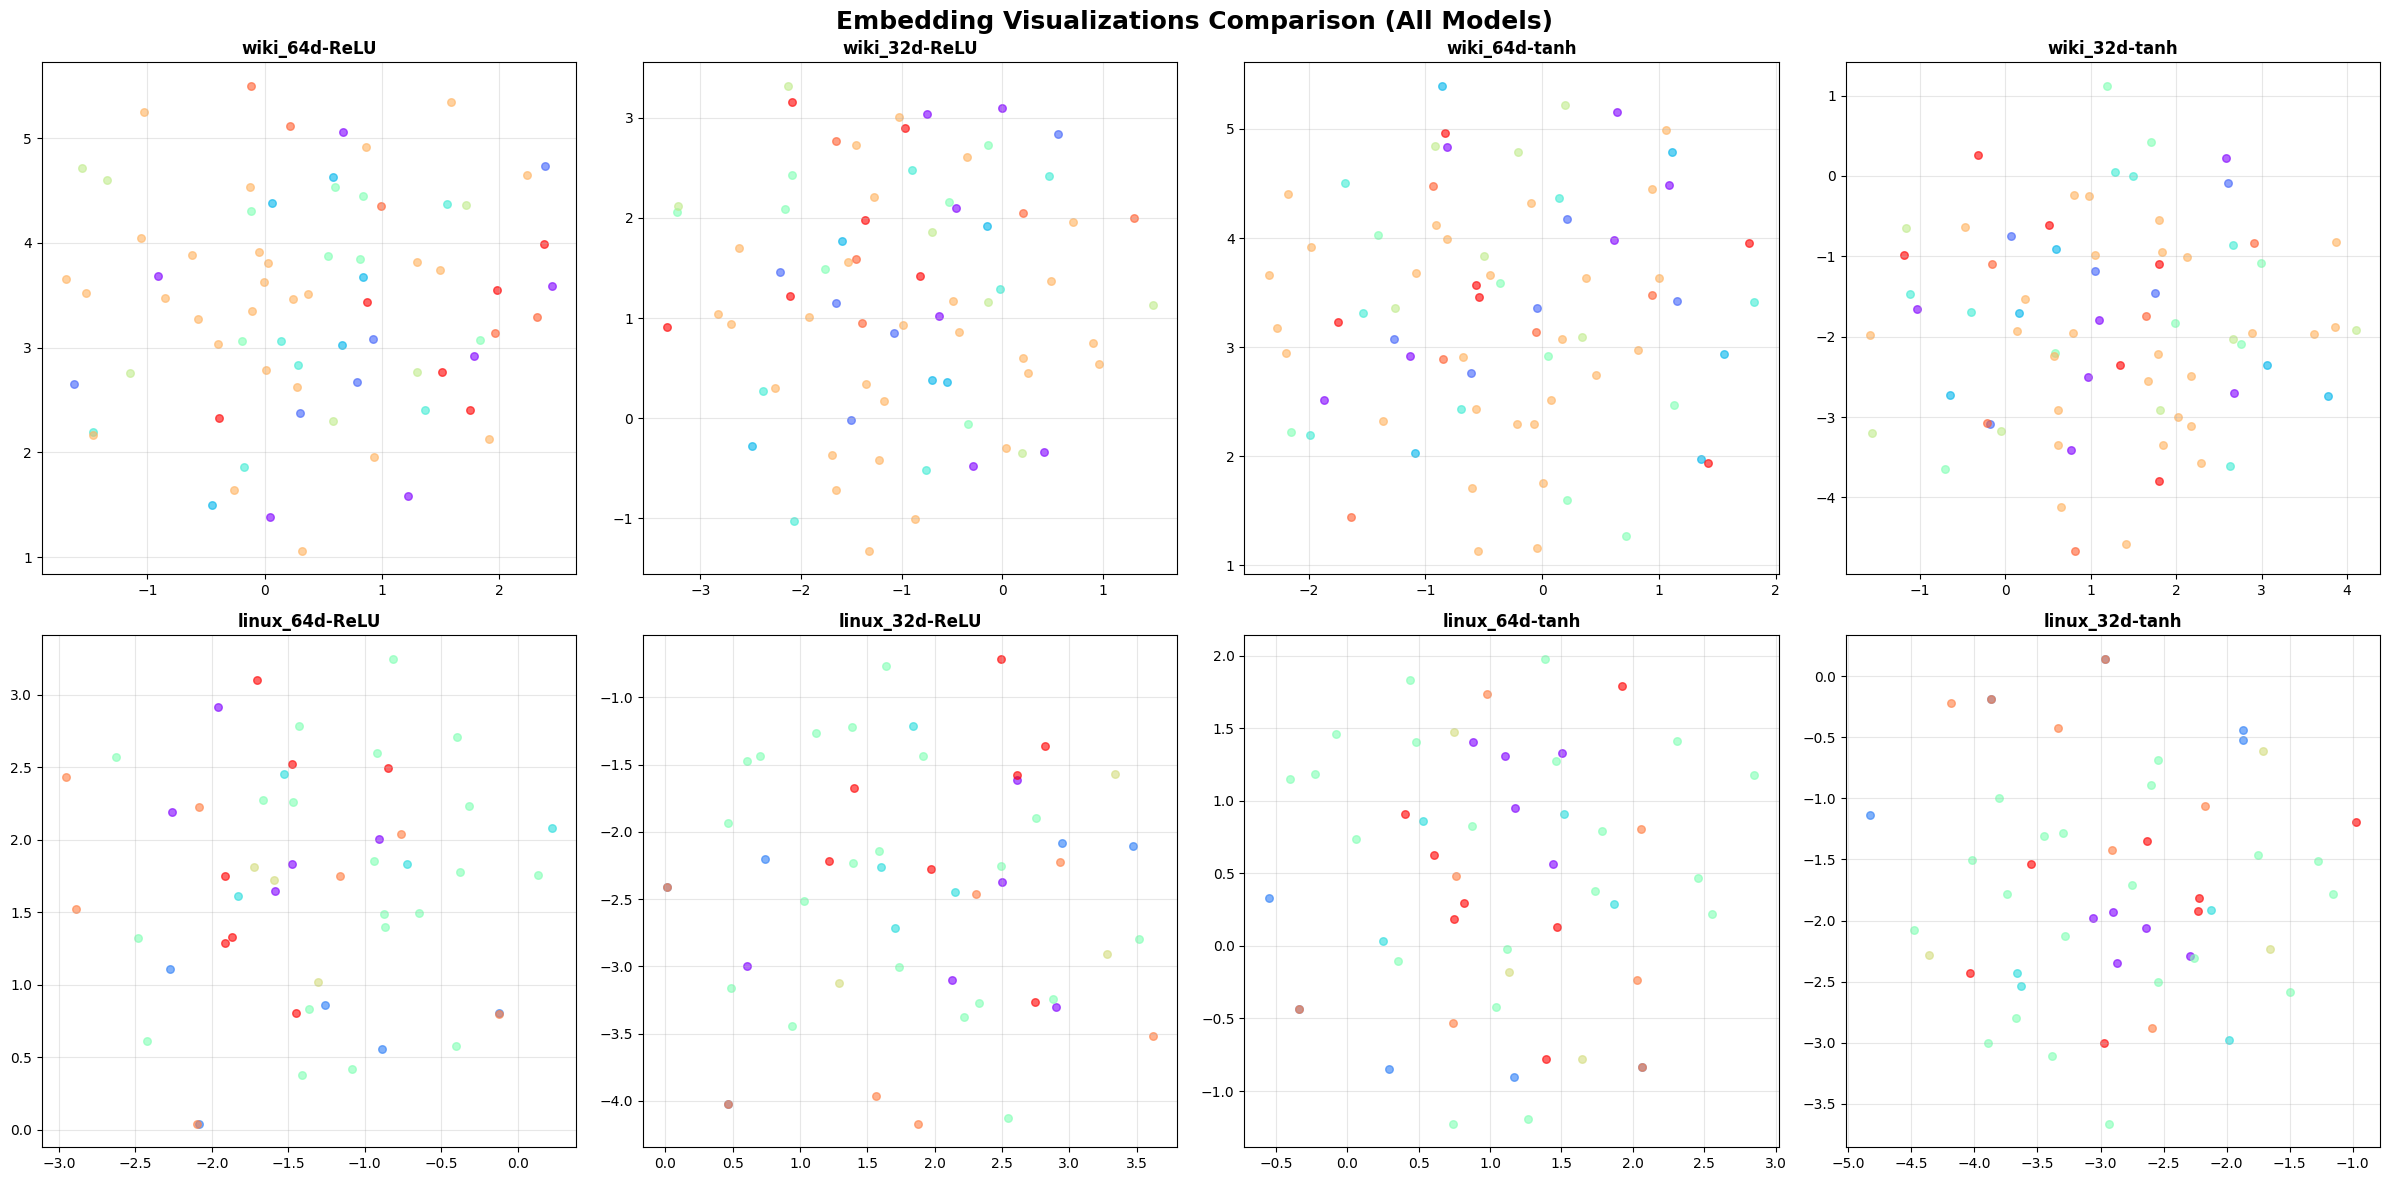

✅ Comparison plot saved as 'all_models_comparison.png'


In [12]:
def create_comparison_plot():
    """Create side-by-side comparison of different models"""
    
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    fig.suptitle('Embedding Visualizations Comparison (All Models)', 
                 fontsize=18, fontweight='bold')
    
    model_names = list(all_models.keys())
    
    for idx, model_name in enumerate(model_names):
        row = idx // 4
        col = idx % 4
        ax = axes[row, col]
        
        if model_name in visualization_results:
            embeddings_2d = visualization_results[model_name]['embeddings_tsne']
            labels = visualization_results[model_name]['selected_labels']
            
            # Plot
            unique_labels = list(set(labels))
            colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
            label_to_color = dict(zip(unique_labels, colors))
            
            for label in unique_labels:
                indices = [i for i, l in enumerate(labels) if l == label]
                ax.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                          c=[label_to_color[label]], alpha=0.6, s=30)
            
            ax.set_title(model_name, fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Comparison plot saved as 'all_models_comparison.png'")

create_comparison_plot()
